# How to use perplexity to select an optimal VBEM prior for RNA transcript quantification with Salmon

Spencer Skylar Chan

## Introduction

Suppose you performed [RNA sequencing](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4863231/) on some cells to extract the RNA fragments inside of them. You now have a sample of RNA fragments (reads) and you want to know how many RNAs came from each gene of interest (aka transcript). Counting RNAs is useful for downstream analysis such as differential expression, which computes the up- and down-regulation of the genes which produced the RNAs. Knowing which genes are more or less expressed is useful for studying diseases such as cancer. The standard approach to do this is RNA transcript abundance estimation, which can be summarized as follows:

**Input:** RNA reads and a transcriptome.

**Output:** Expected value of fragments mappings to transcripts. Equivalenty, the expected number of RNAs generated per transcript in the transcriptome.

One RNA transcript quantification algorithm is [Salmon](https://combine-lab.github.io/salmon) which is maintained by professor Rob Patro at the University of Maryland. Salmon can perform transcript quantification using Variational Bayes Expectation Maximization (VBEM). When using VBEM, Salmon has the flag `--vbprior`, which is the per-nucleotide VBEM prior. According to the Salmon [documentatation](https://salmon.readthedocs.io/en/latest/salmon.html#useem):

> The default prior used in the VB optimization is a per-nucleotide prior of 1e-5 reads per-nucleotide. This means that a transcript of length 100000 will have a prior count of 1 fragment, while a transcript of length 50000 will have a prior count of 0.5 fragments, etc.

This prior is essentially the background expression expected in this sample. A smaller prior size will result in a sparser estimate. A larger prior size will result in more non-zero estimates. It is important to select a VBEM prior that will result in the best estimate for a sample because increasing the quality of the estimate will increase the quality of any downstream analysis and applications. This makes the prior a _hyperparameter_, or a parameter that affects a model's prediction. The general strategy for hyperparameter selection is to run a model repeatedly with the same input data and varying hyperparameters, and then select the hyperparameter whose output has the lowest measure of error. This is basically [model selection](https://towardsdatascience.com/a-short-introduction-to-model-selection-bb1bb9c73376) in machine learning, so a sense, **VBEM prior selection is a learning problem.**

We could make it a supervised learning problem and evaluate estimates directly with a known transcript expression distribution (aka the ground truth). **But we usually don't have the ground truth.** If we have simulated data, we can compare the transcript abundance estimate with the ground truth from which we simulated our data from using a metric like Spearman correlation. But simulated reads are not as interesting as real reads extracted from cells. With real reads, usually we don't know the ground truth and want to find it! We could use [qPCR](https://lexagene.com/what-is-qpcr/) using fluorescent primers of the transcripts of interest and measure the fluorescent intensity (more expressed genes will have higher intensity). But qPCR is not the most reliable way to count RNAs, so most people send reads for sequencing instead of doing qPCR with them.

Since we can't rely on the the ground truth for evaluating transcript abundance estimates, let's evalute estimates without the ground truth! In other words, let's make VBEM selection an **unsupervised learning** problem. We described in a [paper](https://drops.dagstuhl.de/opus/volltexte/2021/14357/) how to measure the accuracy of an estimate using a "quantify-then-validate" approach. The evaluation metric we use is an adaptation of perplexity from natural language processing to transcriptomics. In this context, perplexity is the inverse geometric mean _per-read_ likelihood of a held-out test set. To compute perplexity, we split our reads into a test set and training set. We *quantify* an abundance estimate on the training set, holding out the test set. Then we *validate* our estimate by computing the perplexity of the estimate with respect to the held-out reads. Figure 2 from our paper shows the quantify-then-validate approach with an additional smoothing step which we'll discuss later.

<!-- base64 encoded figure 2 -->
<img width=600 height=600 src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABUIAAAJcCAYAAAA8QN5oAADfiUlEQVR42uy929HeuK6u6xT+GJyC
Y3AKrhoZOIOZwgzBKXQKfT0uVwidglPoteG1MQaM5gGkKImH56lS/YfvIImCCPIVCHz6GwAAAAAA
AAAAAGBzPtEEAAAAAAAAAAAAsDsIoQAAAAAAAAAAALA9CKEAAAAAAAAAAACwPQihAAAAAAAAAAAA
sD0IoQAAAAAAAAAAALA9CKEAAAAAAAAAAACwPQihAAAAAAAAAAAAsD0IoQAAAAAAAAAAALA9CKEA
AAAAAAAAAACwPQihAAAAAAAAAAAAsD0IoQAAAAAAAAAAALA9CKEAAAAAAAAAAACwPQihAAAAAAAA
AAAAsD0IoQAAAAAAAAAAALA9CKEAAAAAAAAAAACwPQihAAAAAAAA8Cj/+7//+/f//M//8JOf/OQn
P/lZ/IkQCgAhbMfB7/zO7/zO7/zO7/zO7/x+5fc7xqqp/fE3f/M3f/M3fyOEAkD3U3YG7/zO7/zO
7/zO7/zO7/x+9fe7HtoDAACUNA2EUABgcAkAAAAAS48pGasCAMAbfgIhFGDjTuOOpycAAAAAcA53
L40HAAB40k8ghAIwaAUAAAAAyE5E74jIYawKAABv+AmEUICNB60MLgEAAABgxjElY1UAAHjDTyCE
AmwKT9kBAAAAYNYxJWNVAAB4w08ghALQaQAAAAAAJLkrIoexKgAAvOEnEEIBGLQCAAAAADw6EWWs
CgAAb/gJhFCAjTuNOxLbAwAAAMA53CmEMlYFAICn/QRCKMDGnQZP2QEAAABgxjElY1UAAHjDTyCE
AmzcafCUHQAAAABmHFMyVgUAgDf8BEIoAJ0GAAAAAEB2TMnSeAAA2MX/IIQC0GkAAAAAAGTHlHdF
hDJWBQCAp/0PQigAnQYAAAAAwKNjSsaqAADwhp9ACAXYlLsqfAIAAADAWRPRO8aUjFUBAOAN/4MQ
CkCnAQAAAACQ5C7BkrEqAADU/AQRoQDw+qAVAAAAAM6aiBIRCgAAT3OXn0AIBdh40EreJQAAAACY
cSJKRCgAALzhJxBCAeg0AAAAAAAeHVMSEQoAAG/4CYRQgI0HrUSEAgAAAMCME1HGqgAA8IafQAgF
YNAKAAAAAPDomJLVSwAA8IafQAgFoNMAAAAAAHh0TElEKAAAvOEnEEIBNoWIUAAAAACYdUzJWBUA
AEoQEQoAU3QaAAAAAHDWmPKOiBzGqgAA8Ib/QQgF2BSesgMAAADAiIkoEaEAAPA0VI0HgOZBK3mX
5uX79+/Z6/PHH3/8/fXr178/Pj7+/vTp06/ty5cvv67pX3/9lf0+2VqR/eg+/CavjUaOX47T7ufb
t29//5//838wiovt+ueff/6yEbUbz8+fP3/ZkbzWYitybcQm9brdYRcrIO3748eP/9wz8vfO9gLz
0HvvAsw+piQiFAAA3vATjHwB6DTghWujIqAIK4qIE58/f84Kk7qJKGWRyUnutRpPCqEivJTOKyfy
Qhl7/e3m8QJ0xFZS9jHSLuSa6/fOLCym2ndV8T5qL/AMkQcMPffuDKjIzkNZxpSl/oixKgAAPO0n
GPkCbDxoZfIxHyKe6GRWJomKRPzY6E8rCsmk14sW9nX7Wdnk7xbk/V6Abf2OlkmxnqPsw/6PqND+
AcKqQqi17Zmvf6p9V40IRQidC+0DdxNC7UMOxiKMKRmrAgDATH6CkS/ApvCUfU5kGbhODu31kchQ
FUdTIqSPphQhMfK9UbzgdQcpMU3OS85ZhNg7xNeTqF1DESb0Pa3La+8QQr0QPruw6AXE1YX7J+55
KKP9fu2+unLvzuDrELoYU5YmuIxVAQDgaT/ByBeATgMewkdu2qieyCS3FMFlRRobaRrlLSEUxnHn
NRx97UT01JyHqwiLXghdOUfoU/c85H2Bt6dd+kQRba0IihDKmLL2vdgHAAA87ScY+QJsChGh8+GX
uFshRUWJXEdvl9SnhAv/equoVBNFfMEcOU5f+EgE2NTxl/KQ+uOUNvGTaPk7txRUBAWJqpKIUl1u
r8fko2aj18gfr/wt55WL1JX92chG+V3+l8p5Kv+TfWiRGj1m+X77HfL5XIRsqt1tEZ+Wa5g6H9v+
0q7etlKCjV6HVNvZPLg5W/Zb6tqlvl/OpVdAlXaU6+DTQsj5p0ROL1zZtszZfym1QGqJum9baVc5
FmsfaqdWSC4VHOu1l9w1lf3m7scr/YTdr7zuhXI5R29Lpc/IfuT6Xok0T/UHJZvz10X7Ao16j/SJ
Kf9Qu3e1X7Gva9+Uane9JrbPKbWVfLfvl+V8Uv1i7bxy0er+eOT7c9c7VXRP2lSPcZUcqowpGasC
AEAZIkIBYIpOA64N+HvzcKYqrXsBy76em0DmKIkiKcGmVNTJ211p0m8n+7aIVGqz0bIiDNhJs58I
t+bSk++rFapS0TJ3TWoFoFLFouQc/HnYNk4dZ0Ro8Ncw9boXU1K5aCNFtCLHZK9drWiW34e0eU04
ahU+7JLknqJk0XO9KoTm7CJacKzXXlqv6Yh+ImqDfr+pvuBqITZbpT1qH7X+yx5HRAhVsbV277a2
e2nf3q+k8ken9mX7xVZbq11z//0292jURmDMmJKq8QAAsIv/QQgF2Fh0Y3A5F16ki5KaKPqIJC9c
tDqMViFUJ80yKU1NlpMOpyD4+H3o8fvzUuE0KvBEBLKU6KHtW1q+mhJ1/CTdCgu5Y5Z96/68jfjr
bNtZxB99PSXKtgih/rjlmPTa+rYpXTs5JhV7/Ll4MSqac9PbZu7atDxYsN8pv8tnvR37FBN+f/a6
lYrZ+JQYXuRtFULt93tB1z8A6bWXnmt6tZ/wgqa1Qb9fPU+fZ1a+P/WZ1ujwVpvz94+2i/RX9px9
fxRZGt8jhNbaXfaVE2VLfkX7X293/ryi/sg/FJFjluOVY7PHbD9vbVcFT43uLj1EgjkFS8aqAADw
hp9ACAXYeNBK3qW56MnJlxJBc87gLiE08p7I56NikBeg7HersBiJKvQRnDn8pN63nZ2Q2+PW41Ih
LSpulATA0mv+nEtiW25pfO48fTRbKZLVn5O+LtfNHlNN6Izk3EwJJTmbaomC1n2rcBax49L5+PYv
HWdJ7EzZi79u9jxL1/SKvfRe0yv9ROkhgBca9Tz98ZTaJppCocfm/Gd0Wbd9mCD3mH8YEM0RGhEW
e9vdt6E9RvldhWbrd2rH49sj54/8ceWEdesTUqkKrEArr7M0fp0xJRGhAADwhp9ACAWg04CHaBVC
U8t3SxORVYXQluW7tUl8TwGbXPSXndTrEnY/wdY8iiKWpJbSRoRQe8wtr3lRpXYNSuKE/Wwqmioi
2Ei7SZ8jr6eWKvtrExHVosvRe4vNaF7F3HLhFlsrtf8VIbR03UqvXbWXnmt6pZ+oCflWvFZbiSwx
b+0Te20utzy/JMxF7TciLI4SQlPXVGxH3iffk1oq748nGhHa0u/nolH9Q8LWNAjw7piyJ9JH7Ets
sZSr1z9YEf8stpN6OKpR01cE9FSeW80RrDbrH6qcjM97/HaxOOlfbE7slYshii2q77a5xWFObPon
0rqM8xMIoQCHD1qJCF1XCPVLV+2y1t2E0Eh0Z0+UXu+5RwfAEcFkZESof631GpbECb9UvEWwke+t
5VPsjQi9SwiVCVgtr2Srrd0lhJauW+m1K/bSe03vFEIj9+6bQqiKM6Vcl769ZowI9ZHOXlCKtG00
IrSl3/d9Yen+5SHwOmPK1u+10eH+oV0kp61N9ZG6P3qE9JY+4wRq4mYpd/YbRH3bKoLRqXY3I+qn
Sn1cKbXS6uc2u//hzgDYeNDKZGA9ITSVk1HzpvlBmxeOdokIbRkQPxERGhEmtJK2X8J7QkSo36/0
O9I+tWvTExE6YiDk80rqEmdpzyuRc/a+9TkpV4sI7b2mbwuhIyavV21OjsFHhuXurdkjQv1r4ovk
9drx9EaEtt7Hct/mBHuWx48XWO4YU7aOVa0w79OhqJ371Rv+wZdPv2PtuTWfcK5Qpdin7NcLs6sK
bC3oOa8shK4aEYoQOg92PrCbEBo9t9k1De4MgI2FUCJC1xJC/eQxFUFk3+OXeK0qhPrXZJLiz00F
4lol755JRmqyn5p0y2BFxaSSyHRXRKjPF+vb4kpEaClHaMu1s8t6RuQIjYjk8p7UvRKduNp27BWM
vADulze9ERFaOs8WUbLlml7pJ/xrqZyvutxP+4dafl+9b3zl8ZqQ2WpzKn7aIkR6DXojhVuFxTsi
QnMPSGpCaDQitFYcTieJ1gblmmsOVnv/+ShRxj9rTERbxqr+PrD3tO2DU0JCzd/0imClB2B27NKT
y3pFbJ9cEzdnEUJHjSVXmm/A/Vj/Vurj7EP4VZbGR89tdk3jljtDcx2UFG1xMvK6nJg6iJzjuZK7
pWV50+zOSSfB0hZXn1TppNcP2lcYiK143DsNWmGM4/ADk1Les9wyy9aJcqnP9lELKdHAR96UXksJ
mT6CMtW/+YrRem72++13ewGvx0+kzl/aT/djj00H66lJlbzf/z8l6vpjtv157Xxy0SViPz4CrSYA
1qrGayV1f0w1IU8+I/vyNuFt0tu8DABtm+cqnPv36XlHJ1L+XtF+MlWYrCRSq7iWWj7s/ZOvbK6V
sf25pSbSLRGhvs/vtZfea3qln0jlClb79/eW7jcVQW8jslKfidBqc6lrpDbg7SpnF/K79gXyWTsm
jQiLpT681O6laJRUMSPZvL37h0epiHltD40o1fd5O7RtYPej/7fnIsen/z9NcHpDKHo7R6j1RT6q
09pcan5QGyOlijL2CE6pMYgtOrZrntDU+GdlIXTlHKEIoe+S8pG7PJh769yWigi1gzHvjEp5VHJP
X67kbmkRFlqqDN8hcJY6Kj9JTS1dtAPakkPxg/JVnj6setyjbKCn0yAiYr6JRDRip7b5wXRueVbr
YCk1MK3127XPl/ZREppK/XMtr2grGuFVa3Pdv++TIzn0SseshUhq55MSDiK5+yJtlRICIzn7vFAa
zZGWErFS3x/JU2iFqtZxSjQPZDQPXCQa6ep1k2MqfWdJaIrst+eaXu0nvMgYzUcZyWfaKor12FzE
prxtlO45bZe72j1yTVrzN9v+3AusUTE/ldOxFBk/y1h+d2aoGm/vsVbhzD94q61QiJLqJ7Qwk52z
ahoH3xdp0SAbFCR/+2hs7dPlp92n3B+l/q1UxKk2p7bFg2rF3yI5pUtRuNo2dn+pVUBRZF8t5+2v
vy3kpJ/19l8qkJnql73NynFoUJh96Oij20vjG/9AVaPla0Ko7id6fbVNbToSfahl7bEWrKX79f5S
viO339RnpH3s6pBe4T76nanrIp/Vtrd9WGuuYF84LDXGSfURtt3tvdLaR2h/Y89Nvs8GhPSeW64P
SvWFb/if4UKodTSpp16RgXvqxuvN3ZKasNqOSF7zHdnTApvtwK4KobW8LAihcxKxgVmenkA/fsKX
W4IY2bwD8d8dfZp9VQgtTWIjQqg/zlR+vdTArFZpvndglMo5J74s9aDO55S0VWn9AEsjHK8KoalB
hQ7GUgJBixCq7eoHVxqxU7p2doCokw153T89ThW3kPfatpJ9pgajqUrAuWvT2u/K/rXitI98VF9j
7wM5Fv++2rF4m9CVKKm2vSqE2uPosZeea3q1n7DHK21i20qPOTdxT927tc9Exx1Rm7OVoVvsNLV8
XnNxXhVCS+0evSbyPnstdMKq967tq1PiUuqa+Pfp0nbfD6QmYoLsUyet3k5yn4E5x5QtEaG9BbG8
rafmD71Lo2tCvvUtkfFX6YFKaYyQEhUiDw1Sn6s9pLQrG1rGsKVicS0Caotv7y3eWHoAVjrnqBCa
spvSQ8DUvL82Di6NIVuDLVptNSVqRh6s+XvTRlO3BtKVNJXW74wUYesRC2sPCu/sIyLF5fx93mpr
tT4omrZomarxLR1Xi9O5Gq5eG3S/lVTYd2IRkTmXC60lL4uNHF1pifmqxz3KBloHrUSEzoVfHj5y
6Y3tT/2SMQAAAIDZxpRRgbU1/U9OaMp9rhYxWiK6msJH9uVECxXzU/NTFVV90T8/70sFj2gqFy8U
+rGoj5KzuZBrqVx6l8bb8/b7aU0nkBLMa3m8vSYh55ZLz2NFPj+ut+dcei0nYtr91nIo565TSggu
zRd0Pl1K8VOz1do1y6VLSa2+sOltvGiW+kxLdHjPd9p7yaaN8imGSql+ogUDI0Joqd1b+ohcAI3v
C2uBKLlz89+vq+rk2KztRvzKEkvj/QnXhKqWfBy9uVuiHfMbQmjKcfaKK615WWAORtnAk50GXMMO
UEZeH+vAue4AAAAw+5gyGunTKoTmhCaZH6VETv/+1gfVGsleizSrzUFbiunZubF/AO4jsT1eRMvN
5WvpPPzro3KEXpnTarvoUvPId5Y0CS+eeR3iynm0FM+0x1S6Tv54/dxSPqtR9fZzEV2m91xLoq4X
qfXe9sdjIxr9/Rp9cNHznSmNRVdFqKinq8Fy16fUX0X6tjv6CBsRavvg2vFEzy2VYzx3HUb5iWZ9
8K4JfvSkokbcm7slYiS1iNCW3AnWSLQ9NIeGdjryeyQE3xqWFiqwS4dSzi6yrCCVkyQn0vnvLuUO
GZHrpDbI0O+X7/PHncqxkcqdkqsqK/+3SzTtvlqe5kaXRbTaQM+glYjQ+bgjAtgOeuzTXQAAAIAR
QuhdEaGR720RFlKf9fMZP+cspS4qzUs0PYSPBvNpG6K5MntFjlLBu1QqAJ+SRceNfm7ix5NeZPPf
PYMQqscp4pQIcKVcnlFNItrWV4VQn3IoKpL66xQpliT7EjvwGkfpHug911rQj56PXfXakjIs2h/0
fGcpBYGmDOoRN1v6tjv6CNuPaXqulB2kcpb2Rrv2pjdYIiLU50prFUJLT996c7fUjCSVI1Qbuid3
QirXlw8x1qUZ0Rsw996Wm7rUqfibpue8R+Q6ae24aqJi6Rz8zdTSMdpzn10IJTJwTnyuwdm+DwAA
AMCOM+4YU45aGq+F1nxxrZyAV1u6G40IrdUtSBWA88d+txCamkvk5tWRwKNRAuZdQmhkftUSEfqk
EBqNCK1dp9LxRgoMjo4I7Vn9OIsQqjpHLTfn7BGhvt0jRSGvRIS2CKGRdJrTC6GtnVaLuHkld0vL
xbCGnHOKpdwJkRvMioARpb4mhLa0f0QItZ1jNDdMT66Tlqi1HiFUBzqaJ8N3YDU7sUsGSonWe/PD
tNhA7+CSiNB5ERsaeX3k+3YqIAYAAABzcNfD9VERoZGckqXxeE9EqJ8zlQqivSmEnhQR6ttaq2mX
CidHNAl7nX2w12oRof41sQX57ogu86YQ2lsYc+R3pgoopu6FFSJC/fXWIo214+mNCJ3R/0wlhJbU
4Ku5WyICqI+ksslco7kTIkJoSThtuXmvtH+0il1rbpjeJ1ujbKyl42/9ft/xjXKCdwqhRIQCAAAA
wBVmjwj1wQ4+BVdNwOudZ9q5QS4atfbdd4gcp+YILQmELUKoPa9aoaXZcoTWbCN3LnfmCPXH4yuY
630ifYHeuz7wLJfaLlp5vOU7tSiStrXc5zY9nvzUfUf0lBkjQu1rto8YlSO0VuxLiAbxHB8R2vuk
7mqHqh1gS+4Ev79SmoDZhNCrTwJbOvSeJztvCqGl459VCCUiFAAAAABmHFNGv7c2OfcCh4ytdQ6T
Wgrs5yC9cxT/OU1/pvv2FZL9nNCLbPZ1P+fyny2Jv6mVbD1V421bpKItS/MoKwzLeVrxq3RutfNu
uR5yzKmiwl48S1WN1/aqrWhMfa+vUZE7Dx+Za69F6TXBaxJ6XP5eqAXvaB0Sf494sbJlBaQ/19TK
URVv/fXRe1v+nzum3GdqpFaI1r7TXgddLaq2Y6+xjURPraLV66NRl1Z4LfVtd/URXn9Qu/X/r6UR
seem9Vr0d2+jtj+w99UWOUJXiQiNCqG9uRNa9je7EHpVLCyF+K8WEVo6fiJCAQAAAGBXIfTNiFA/
no7kvWzJR9crhKZqJOQ2G2WWGv/7/fe8ZtvFCyy1VYqWWg5Jfy6RfeocqPe8I2KXCCylGhWt9Tgi
7ZUSHmv7LNmNBl/lXr96rql6JqVt1DVL5cuNFOap2WIqurRmIy3fmSqqnaqL4vsML4SnzvOudo9c
k5a+y/ebkXPTfZSuuRYRj2iGRIQ+HBHamzthJyGUiNDYuRERCgAAAAC7CqFvRoR6cS43z5F5i3yn
Fzrk/SXBxItDUVRw0KgomRel9p0S0EoiR0mkqIlovj3kmGxkmPwu/6vNw+SY/TFqO5aWIsvx2c+J
2KFz6CvnHbUTOS9fwFmPWb7DtoVeF1901EdIyvGX2st/r7ZTSnSU99aEqogQaq+vik16bVOCtG0/
+V0/Iz/VHmSzQWC6ZHrUNdP7M2WPudohct2kLX26h9JnarR+p7aJ71u07XLHIeef2ofa0hUhdEQf
4YVKOU+NeLV2JT/9OdbOrXTN5XPy+WhKAyJCX4gI7c2dsLIQOjpH6MoRoT683Hd80eMiIhQAAAAA
VhZC344ItaJSy3Lp1jlfrtgSAAA8z5YRoV4AKglj/olKSzRhqdp5y/FFcye05DbxS+99ngqLf8Lo
sYp+S14Wf62u5IYpXadarpMakQrspTbyr6WeQuSWQNSSK9u2b80P02IDrYNLIkIB1sInX+dhxr5o
rqrcEkM7ALRP5cV3qm8ZUUU1h/gwsUf13dgiwLnMEBHql6hGo4la57A9gRoAAHCf/5leCLUCYU4I
jebgqH0uOvhvze1p6cmdUAphTu0vlUjWt0OpzaK5YCJ5Wazjb80NMyrEP2JbqTwYpTYqHVspejP6
mRa7Tl23iA3M1GkAwD1oHy6TPdtvMSnbE3uNc2MaXWapFUqv5saKkvJp2CHAubxdNV6xwQOj+j87
30tVWAcAgP38z1AhNJJfpVcI7c3dckUIVefYkjuhVQgVfOUsn8smKoTq8fbmZfETsZbcMCOSPpeo
CbilNiodW0kIlcmnz7tSspnW/DB+QizXydpaLZ9R5H4kIhRgDTTi3fZJKnzdGfUH9yP9eipySaOb
cg+O1XfZFDQqjMom/qY3P1YLOj4ZGX11dUCMbwN4ljuXxrfcz3Z12CjRUucYqTx4AACwp/8ZKoR6
wWnkoJncLfAEPblkT+s0AGA8Gh24er8Dv6PJ5HuYRYAUcWCmKCkRgxFCAZ7vy2aICBU08GTUQ0Lp
Y6WfzlVQBwCA/fzPp9FfaCPiRi6jYnkWPMFuQiiTRYA10AeJCKH7oLmlRbjr9Udv24MK9LM8VNMo
WnwbwPNjyhkiQgEAAP8zguFCqC0qM2oAT+4WeHKCRUQoADwNEaF7XUtbKK8nykj90dt9uI7pZngA
Le2q+csRTgCeZaaIUAAAwP9c5dMdB2uXsY/ItULuFribltypq8BTdoD5yeUwtoKoFdbk/bbIjvhF
20dpzulUvmKPLAeU/8t7dX/yty2WZ/sQ/5oc09Vl27YCuk1/Y4vg6XmJoKjvTYmLKh7m0uek8nHr
OUg7+kGW/F+OT/M8qxgof2v7+va3D4NzuaG18JEeix3X+Lawx+ltISewapvanNNyvDkxU/bv36+5
xVuX58vx+Tzlmm8854+kzfxn5L12n6U84Dw8AHhmTElEKAAA7OJ/bhFCZfAqA9NREQTkboG7qRVj
otMAgDvJRYT6vklEIxGKRLhSQUwnkSoEir9UcU7+pyKSXaLtBVj5jOxLiwFqQUD9nApZKtrpd14R
oVRgFLFNv1dFQhXl5Pu9eJkT5rS4VEr01dfk++y+rMBmxxi2IId9sCuCohYM1PfkVqrI/31+UC90
5j7rBchUxXj/YFjHXmoT+rr8VAHb+zMVbm2+Pb0G+hm5FlEblvfK53TfVhhN2Yq1YXuu+j0evV4I
JwDPQkQoAADs5H8+0bQAe8JTdoB1qOUItYKoCpoaySifVVEuV6E8F0WoAqwIcv5zNvI0FRmvr/Wg
Ql8pSjD1uoq2KfQc/bHqd+UiRVORmal9WsFWUcHWU1varm2byx9aOs+UgCrXLiW82kGkb8+UQJ6y
yWiO05JIqW2cen+qjfQ1b68IoQDvjSmJCAUAgF38D0IoAJ0GALxMLUeoCqE5UUrFvtw9r8KcF9BK
AqyNGk0OIDqF0EhhqJSoWSvco8vVLSoWl5Z3pz7n95mKNFXxOSU+agRnbiWLCnqpFQclETXXBtKW
ORFcIzVteiG9BqWK9mpT0dU4Ni2A/4yu7LHXs5RCSdvA2whCKMA7EBEKsyF+zKYBmiGntk8n5H2V
+rDUyhWIjR39Q20ZV/gURhF09YuOr6/2Y3ZsomPYHa+zjM80rdZT9xwRoQDQ3CkzWQRYa4BXE0Jz
OYs14q6U0zglXJYEWCsCRr8vggqTpZzfqe8uDXRzA+SacJYT3PznS0JxanCmg+DcOer1TAmXpQJF
KQFVj0OXw8vfMri3uUzt0ndrL6VJgy6Nj+Zmt0vzbfRyyiatbdW2lusJAPeNKYkIhVlQPyn+yfqT
t9KZaToZ9Zf6t/fx6lfJbd2OTWXkx1I9dT1KY41WfNqiUd878zV4cixGRCgATNFpAMB4ohGhuUF+
7XU7ULM8HRGq51mKRLT5PFMTiJal/zUxzz/Fb2nXkjBbijKt5RYtFShKtYHPOyrHLJscn7RHKpdo
7drZlAmt2CJLtgCSbaeavdcG4QgnAM9PgGeNCBVRjPHuevSKROrDrP/QccMbBW7Fx9rCifp3yofn
0r5AbGyhOfJ7xsClsc6IiFB9yC/faQuL7uoPnhyLEREKAM2dMpNFgHUGeCdEhJaiKHWCoyKi7b9K
y9Dt03cv+pWO0QqCqcGzzbuaQo/TT3b0c7mcpLU2yJ1nrg1qtpG7riURUu0pmh8017522ZldJoYQ
CrDemHLWiFDpp+gT1kL99h3jpacRv2Z9Jfb4PK3jIG9LIwRLHaPpmFDHOTvy9FiMiFCAFzpIBq0A
8ARXI0JzxYX893sR7a2I0Nxx2uhG21+XxEN98p6KXiwdo41aTEVulPZZEmb1c7ncUKVI0lJ+0Nzx
tEZC1CaRtkJ9S9SKtGfunG11eqWWu3WGwTcA/PfemzEiVPtM+oT15ii9IlHvg7Q755iah1v8q334
F00tA2Pm+W9FhGofaQVxGRPt2i8REXrBYfllXGIoJwlU8DxP57KYZZDBwBBgDa5GhNrl1ilhSUW/
XNX4pyJCS9XSNfl6qhJ7rriQfI+PXpTv0fepSJral7wm+1IBVdrNHlckJ2mp4rleK/lp+2IbSapJ
/mvn6Y9HPqsRpyoylqI37SAyUuRJ7U3GbL5dahPblHiasrPaQFq+x+8XIRTgvTHlbBGhdgkqfcJ6
IsouEaHq+9QO7UNW9I1neDsiVMYrdvwtY5crK2pWuYeJCO00ttTGU5NnUCG6lKNtFuySxysJsPVp
3R0OadawdyJCAdYbVKSETFv5vHRPq4+V77C5qnSQnhqU2QG87x9tFXD/mvXnrbmu/IBVfsrEQQsN
lKqF26XVWrHSVlKXz9s2VGFPz11el33pe9QXqrBoIxpzIqr9XtmnfNZGAtgcYLI/X6hII0e0krr1
baX8oDb9gV96p8eqbaBtpOKytQl73fV81U7kfXrMehyyr0jlUyuca+Em/e5ctIaOR/z7c6Kqtrte
P11+jwgCcL+Pmiki1Ponv/n5jQbhqB9VH9Nb0Tn1fZHAHumrfP5k+Ts3/219v5yPjUaU4/PvT83F
cz46157S7+rDRH1N/rbHKvtO9cslHaA2z8vpCH680Hq9feVwuyoiVfDIo75ctQwdh/g8ofpQNCUg
+crnPnBMvt+O6+xrsp/cOEwFOj0P2a9tF/menD21tqOOF3wxHdly6X6i75djkXORY0kJ4HaM4e+D
UnXz2gP/VM5z32Y6xrFL4ntEUP2cnoc9Nq9h6LXUB+tqI7lrk+uzcgUtvf3YttQxV04IbbWDN/3P
owqObXy9Ie3/eGry7HVYoWJdaSI+k1A7qxDK5BBgbmoDez8hqU0YVOjzA1f//tp+W19r6Qf9IEnG
AzqI1wmI77tUqExNOO0kxIuOVpjUQZz9bitA24lEKWpSX9dr47/TvmYnLykxz1+X0j5V/M21T2pQ
XBrkWhFcz8ELyKUJVgo7SLY2WBII/FLC2uTMfrdOtluW1wPAc4Ll3WPVWmSSTQtjhST9XKtgYb/P
C4z6kCvV16Ue+uhnUsFAV96v/aG8P1cwMLIkWH2unS/6sYP0+fK69TWyL91vzn9cicKLrGSJXm8/
jlHfp0LvqPlnqdp2yv9Znyk/1bbkc3ZMp6JrLp2QFdK8n9f3pGy2tR01v7svGmXHer3v9+dSEkL9
+EHHRrVURilbVFuQa2FFzpTIfRVbXEntTwtD2Xvbt53eX/Y8UyJ7rs/KXX/bp+gDf/0u29apsWiL
Hbztfx5VcFJGrJ16bjkf3Ccszi6E2qIZVyNC7xwYEhEKADAG+zT8NEr5QQEA3mTWHKG1yCQbgZ/z
Ny2RoaVchDon8MdSyuGtYosVaVrfX2uDXNG/mjCh31tLnZMSUWrL1+9YGh+93ilx1ouh9hxHrlgt
XSu1rZQ96mupIoyl77QPe1PnkRKVe+6bkjit9mzvmdb31z6j7ZMT3lXUz4mE3hbVxlLiaSnF01W8
oGvtU9uj1AfZtEZX+iy76ilF7qF8z3V90/+8LoTOhF6gXGexMtKR2eiP2YVQuUmsCDpjROjVHDd3
Q0QoAKxGKj/oKegYhDRBADDjmHK1iFDtU3PHrQ+fWpZrahqX0rH4/ZWK8umKBi96jHq/kHvAeEUI
rQmdtYJGd0SEXrneval+RtprKc+lvlYSO0uvleb8Psq4px19ahxvi3Lf2LZtfX/N5mo5QmsFQ70t
5vLq3z1W1fPIiax6HqnioEJqVVVPn1UrZlmLPm25rm/6n0dmG7mlfd5gNeeIzWWRy2fpc5Hoe2z4
bsp5+KVjGnbsc82os9BcE9Yg9BitoKjnkcpLUVK+U7knckYi+5b322VhavS544lcg56Iy9xx2yIQ
qY7T56fwSwp9pxTN/1M71twgwObf8e/VLWVTLe2Ya6u7I56ICAWAlcjlBz0FOe/c4BYA4E1WjAi1
eZWzE+FOQU5zFsqxa9+dCjRprXDe6gcj78+10YiI0Nx+34gIvXK9nwpsiQihpUi/O4RQv9/edvQB
VzXRq/X9kYjQ0tw6dcy5iFCfS3OEdtKimeXavpQbuRbs1tpnlbSWks21Xtc3/c/rQqgmg/XRf/IZ
Lx5JI/rl0jmRLFVsovY5K47aIj0+F0ruMz6/Qy2a0RuK32p5TGrHkwqLLm3RiEubRDq3eYOv3bj2
mtlOqeUGj9iePcdUe9u8K1aIzz2ZqTnOVH4RzeF395NHIkIBYBX8g8/dU+XoGEN9g/oKokEBYEZW
jAjtFUdK2Bx5GoCjc9mU6NQqhLZWRI+8/w4hdMaI0CvXeyYh9OmIUL/fK+2oBX+8kFjK4Rt9/5WI
0Nwx5yJC31rxWWv7nmrtd/RZkdzMLXbwlv+ZYml8RPjSXBT+vWooXmjz+TW8qCrfYwsspMKMayJf
StyT/8n3+uP0Fz6XNDl3fj3Hk8oxMmJpvBVfdd+2KqwXDv056cTPJniOtNGVpfGljqXUXppbJ9cZ
1irNldpZz/2uiS8RoQCwAtEHarthVx+UKgEDALwNEaF//1bkNzWfKIkK0ZVsve8nIpSI0LcjQlPX
yY9zrrz/jYjQp4lGhEYFxZ4+68rDlRF28KT/mUIIjS6F9uKZbZCa8Jjbt49uzFVNS31vyz6tMGjF
tVQCayso5jqBnuMptcOVSatcB203OV45V3uz+UhZO9nzYmfqJhsRfl7qWGqdea8Qqo4kd9y1RMQj
BpdEhAIAAADA1THlqjlCIxXlW/aVa4ec6NQa+ND6/ppok5uP7JojtOd6nxwR6tPa9bSjpixMYVfZ
9r6/ZnM1IVQ/6/dZyxH6dOHO2nm09lm1fK85++jNEdpzXd/0P1MVS2oRvqQx5f0+x0FOBLShuSUR
NpXfMfe9pddK5xuNgK2FcLceT+QaRPDRtTaiViNic/tsWZ7/dERozW5bX6sNTFqXy8zSaQAAAADA
OexYNb41TVVJVJAxvQZ+5AS6UgEU+5nW92sbpFa26VwjVTVe58+p+ZXMs3PnE5nDzFg1vnS9d48I
zYlaKZvuaUe9JtFUcq3vr9mctk9OhMu1bS4itGbfeg+OTuMUWeJfe4+0qV8t3Npn1fpVtYFcnZfe
lIJP+5+phdDUBbaNX9r8hfEFcHRpvC+c5A16VERoawRsTgidISLU5nKLLGlsOVfbQa0eEVr73tY8
QD2DSyJCAQAAAODqmHLGiFBdXaUrBzXnsoqCOtaW13UOICKf1mnITdhTyOdUINLvkp/2uzQwxM8n
bc0BjfTUoB55v5+ftL5fBQ0bkCLnrsebii7VeZZ8Vl/X85HP6Hml5sf62ZxYZtO1pV7X+bfOF2W/
0SWzuu9UO/dcbzsvvzsCUOejfu5no+V8O1i9IvWa/c7cddI2sXUw7PUf0Y72+PUz8r36Gd9/tL6/
ZHM2B6ZNNaR2lXtQYNvH31O2zoc9vtqDil7siuFSX2tTO2r9HD1XbQfbZ2ibtfRZdh/ap2jfqkXN
c8Jz63V90/8sFxHq36PVt2vRkLajaMlH9kREaIsQNkNEqO20xShzBZv0JiwJuxFHR0ToXINWAAAA
ADiHWSNC9dh0zC0/5W87qVcxxK8O7BG9rLCiAoKdb9lj8XMX2Z+di6rYmIsqa32/7NvXvhChoxS1
JiKHrx6dq3ehbVYqYptb9eiX8lrRxs7nW+bAuflsy/WOBCGNun9ygVs5fUKON/e50mveHvX8ve2m
7pXedhTE1sQ+RU+xdii/pzSW6PtzNmWvu/yutq4PC3qufUqg9gF4VuAbRckGSjbl7/fU9fTnIJ+J
9FlWLFd7sW2cs7lWO3jT/ywXEWoNxRY3qomA9nUfBVoy6DsiQv1rqScbqsR7g3k7IlQVffuESG+y
VNStkCpUleoM/ZOVXXKE5myrlmtoxOCSiFAAAAAAeFuwZKwK8CyRHKEAp/qfx4RQXyAoleRVQ2ZL
EZpeMRcBLqfWK7qUoSey0BdTshfBi6/2NRvinqpI77/XL0uwCroVSVsiQlMGY9tBfldxUZdbtF5H
ES9tyHxK8JSfdr9W1PTXzl4bu6xC96VtIe3Xch3fiAgtRXzaZQ5UjQcAAACAmQWVWSNCASB/3yKE
Av4nzSNCaGlJuohFtZyZltb8mvL+XEi1CFEaSi0NnKumlwqbzoWjl16rFQNKLSOwImjP8Xjxzwuw
PRGitfygqbwZtetmc1coNj9Fa7i4/55clKy1jZSwal9P7a+W48bm4LBCt94TvSHi0cElT9kBAAAA
4OqYkohQgPUEJIRQwP+keV0ILQmVuWg7+Yxd3i7CkyaLFcHJ5onRokglQS0nVt4hhKaqldlj1u8o
VbS7Ir5q+/lrEsnNYo9ZhVp/7KX8DzbJt89TkctPotfUf6aUIydieyWbq7W3b4tajptce4/OL/JU
pwEAAAAAZwkqRIQCrCcg5VbiApzufz6d0oBW+BJRLVfgp1QBD2A158dTdoDnfIw87On9CQAAMPOY
kohQgDXIrcTkXgP8z385Qgi1uSYlMs+KnDoR9flJ747WA1i10wCAf6L5qq246bfS/wEAAGaFiFAA
ANjJ/xwhhNplyRIaLk9JvBhqhVBf2AhgRXjKDvAcXuT0EZ+1/wMAAMw8piQiFAAAdvE/RwihpQJB
qQJKROcAnQYAtFASOWv/w+cAAMDMEBEKAAA7+Z9jcoRq1GeqeI5EiWrBJYBd4Ck7wLM+phb5WRJK
AQAAZh5TEhEKAAC7+J9PNC0AnQYAXIOIUAAA2BUiQgEAYCf/gxAKsCk8ZQd4jprQSY5QAABYeUxJ
RCgAAOzifxBCAeg0AOAi0SJJVI0HAIDVICJ0bTQ13CzjDSlaLCnpvn///uu4Thgj/vjx41ctEknJ
l7q/pB3kPVHkWmqxZykE/WRf0HqsADP6H4RQgE3hKTvAc0SWw3uR1L4OAAAw85iSiNB10boYs7S1
r9exMyJS2nMVUdqjQnXqtRS+5smTAnfrsQLM6n8QQgHoNADgIjkBtJQ3lIhQAABYASJC10ZEq4+P
j8fHGxI1WLq+Jwih9h7KCYj6WmvhZhUlR0aEyrg0FbV69Vh3RIptPxmNi/8ZC0IowKbwlB3gOaKC
JxGhAACw4piSiFBoRZa+l64vQug17kh5IOI10Z4x3ni4gP8ZB0LoBkieFXlyI3lH5PdSByw3rHSY
8lOe5Mh2d54POSZ5WqL7l+NcBc3pIse92kCNp+wAz/YVLcWSiAgFAIBVICIUesZFteX4CKHXuCMi
VDQFhNA6mvKAiNB1/Q9C6EY3YumJkDyRk45Nk1OrGKodqIR2331suq0y4NEE1LPl1Wk5fp6yAzxD
Kdozki8UAABg5jElEaHQMiaSeSdC6H+ZPSJUNALyf8ZQLWWmAmT4n3YQQhdChMtUxKdMolXUTKFi
pM3locLok9XmJLJyxScn6riICAWAHBHRsxQVCgAAMPNYmIjQNZF5l1Zn93MwmRtKMIyKkfa9usnf
pRWHufleavO5J60QqvvW1Yu1fcv/xS5lpaG+X36PrnJMBetYUdYXJLLHntq3BhblcmfmhFAZE5bm
mrov2y7yHfK5UkRoyzHKd+WumW2T6LHafarekLqOd9ifPVb9brsaVv6X6nNyx+7tyX7nqsFe+J//
v/+hadcxgFLi4hJ6w/Z0IiOZ5Th62p6IUACoDbhqy+BLRZQAAABmHlMSEboeGpWZil7zIo4ITiKs
qagm8zUVpeTnHfMnK+y17FteF8FKxS39X+ucTdpDBcaUfatAaI/B7tsKkDYKNiWGpoRQ/V9u9aHd
lxXkZL/yPz12H5XYe4x6vqWCTpFjtddEoyd1ZeoT9qfnIfvUMbYVjv359djTHflZ4Vn/gxC6ANqB
9Dgh7WhmCHFfLT9oiyM/qdMAgH8SjQAlRygAAKw4FiYidF1KkYMqRKUiKUUM6l2+3iKEtu67dD76
WvQhc0ls06hRK+DpeaXsVt+fCl6KVI33bZWL5PXt41/vPUZ9raQb5I61JAyWtIw77K9kezYC9Yo9
3ZGfFZ71PwihEyMdiQ0Pz4Xa175jhlDtWY6j9+YjIhQAan1cS6Ek/34AAICZx5REhK5LSaSqCU1P
CKEtr+ucMhdco6JbS1SoLp32yDzci3e69D+1wnGkEKrFpkorQnPXtfcYSxGhpWO1EZg5dMm5P6Y7
7E/P30Z4KlpkWtus156ICF3f/2wjhKZySmj+DL1htVMRg9b3psRF7XhynUAqV4c8XVDh0t9IWjVd
83HqPn0Vd3sj2SS8ftMbUcPN9cmGnUz7trBh53qOuv9cpKm8R47Z5sqQ9+cMsZSrpTU/qLzP5+DQ
Y0116tJ2Nt+pHrvPp1ISHKQt/bHL/4gIBYAatYjPWlV5AACAWSEidG0iEaFZsWAyIbSUg7SUjzTS
PlYX0GjE3BhN5/dyfvJ5n4Yg1x5RIVTPs3R/1KISW4+xNyJUj7V0rXPHeof92cJPVgNJtVPUnnyb
EBG6vv/ZQghVAUyEMyt0+eroqeS2KVFNb4hUiLZ9amBzWMi+VHTzeURS+7TJnFV4zT2JkP/7ztwL
nbnP+rycui+7pcRgbVPZj7apzdXhOzrtOFU8tP+37R6JfNL29/vW//scI75Tl/3J/+Q49H362Vo7
2WTOsm/biRIRCgA5Svk/a/8nIhQAAGYfUxIRui47RYTeEaCimoEVu2TumBIE7XxYg3Tk89K2tgBT
rj2iQmjkPHPXtfcYeyNCrxzrXfaX0iG8hnPFnogIXd//LC+E5oQ524mlXi89KdLv9IatCZXlBioJ
qLkl7LrPVGSiRiJ6VLjMXfxUEufoeeZyXuTOP9dB2hD7XCGkkgiZ6/BS36WiZymHRy5qNPdZdX65
NtZrQ0QoAOSIRISWhFEAAIBZISJ0bXaMCB09L9OAJp0Xp5ZV27ZM7d9WX8+1xx1CqL+uvce4S0So
R4PWbICTBqT12hMRoev7n6WF0NTTG09K1Kvlq9SqYTmDz01aIwKir/qmN2dOsNRzzImr2hmlbsLa
eab2qd+XOgdxDCoK2mhYPa+cCFoTa1PHlTvmSDLj3PXJva6OL3f85AgFgBqlAkkRURQAAGDmMSUR
oeuyY47QlqXvLccrNin7SAXw1PY9MiI0cp6p63rlGK/mCC19LhfodIf9yXGkVvYKKnzqsfbaExGh
6/ufpYVQFeVKk0gVuXxj1sRDCaNu7RhyUZ21zk87pNQFVnE1d456E5YiVKMiqYqa8p2aU8TmFUmF
k0fyl/jcqC3Cgny/tIHs3+b7TDnV2pOZ1OuRzo8coQBQo1YgKSeMEhEKAACzQ0To2uwUEWrPpxSc
1DrvtOnj5POlaMrUvFHmznYZdosWUKvEnrpuqQClq8d4V9V4m/buCfsraQ8pTafHnogIXd//LCuE
RgSsXMSoLpFOiYfaOXhj1xsq93Sh1nGUbpaSMCviXyo6VTuzUhv4/KC1ffoCTbqMX25+Oe9U56Bt
WZrI+6UGNeSY9DOyfzF+FRFKof49EaFXOvzZ4Sk7wHNECiR5UdS+BwAAYOYxJRGha2LrVfi2tsuk
SysaewQfnVdq6jRdnqxz6ZZ95yp/62s615XP5FK/RbAiYW6loO7X1vqwgUG5c9LvTqXY02P281FN
yyebtr8WPJbvUSHU6xO9x6hisC3irAWfa8cqn9X5u105amt8lK7xSPuzn5O2UluQn6lUeT32pMFq
thC1RhPDGv5neSG0VME8ldtRnUEq3N0+CfLGHo02TB2PdUClDtV3ivo5H52qlCJJf13cgkia2meP
4Fd7SlMrUpQ7Jzm+lAOLCKE9EaG7CqE8ZQd4zidFokFzAikAAMCsEBG6Jr5ythWdctWx/Rwv93rU
blQck5/yd6qQcO++5fts0VyZb+o+etB5aCmdmxYisudl61PId6gG4YVHu8lx6hwz9ZrVJ2yRZHuO
/vpaAbLlGH2hY/uaFi+OHKvu135erk9qDn23/WkBZxWNbVHl3Li7xZ5sQapUwWiY3/8sK4RqR5UT
p6xhWmMvFcbRmyQl2kXCvXMiXEmwLEV16udyUaiRJf4t+xwthFonG80Pqk/LamLmqIhQew7kCAWA
XqLRoDmRFAAAYOYxJRGhAACwi/9ZPiI0JbCJcCgiXyo/aK64kHyPinD6nfI9quznREeNItWnBzqh
tVGcvYKlL1wkP+1gwUZ1ymv2O0r5Qb0wq0969FhK0ZtacS11DP685Ht8qoFcdKuSS02gx63XdFRE
qG3n1HfaXCpEhAJAjojYWRJKAQAAZoWIUAAA2Mn/LF0syUf4yU8RrUSAU4HSL3lW0UujLEUUEzFP
czrYanGa00QnuT7PiQqcNnel/F/2YQXaUhElm6/Df9aKtroPG81oq7XLcVmBr5QfVPepQq9tIz0n
uy/Zt74vFT6v4rG2i3yvDUfXc9DCRyVsPhkVB+R/cj5yrnpeXlDNpUJIve5vJJsXRI7Rnof8X1+r
ibizwVN2gOeoLX+vLZsHAACYeUxJRCgAAOzif5YWQku5GVRQ887VV0uzeSJsrg0vOgo2Z0Yq14ZG
K6Yqsedyddp9au6U1GuyX388co4+gfJ/Lmxwn/Yc7Pfa/BgqQObyXsj/U7lEVBzICZA5VJzW75Nj
1X37ay7Hlst/o21Se12/1+Y+0eubyomyyoCNp+wAzxGNCCVHKAAArAYRoQAAsJP/+bRrg6lYduIE
s1ZICs6Ap+wAz9ESDZr6GwAAYOYxJRGhAACwi//ZVggtLUffHV36TpQRnQZiOMAz9OQHte8BAACY
FSJCAQBgJ/+zpVKYyw96CnLeuWXxcA48ZQd41u/UxM/SEnkAAICZx5REhAIAwC7+Zzsh1OaQlKjQ
VLGg3c5Xc53K75o3lAgj4Ck7wHOklsNHK8bTXwMAwMwQEQoAADv5n62E0FRBHF/lfEds8SBb/AnO
hqfskMNHKPb8hFib1gRRqsYDAMAKY0oiQgEAYBf/84mmBaDTgLNoKerDUu7+No2KorQnAADMDBGh
AACwk/9BCAXYFJ6yQ46oUFf6P5TbNCckUywJAABWHFMSEQoAALv4H4RQADoNOIxSrsqIgEcE4z/J
CZzRtgYAAJgVIkJhRf79r4/LGwDs6X8QQgE2hafskKMk2kWjGuF3eiJCyREKAACrjCmJCIXVQAgF
wP/kQAgFoNOAw4hWNC9FNMLvtLRdSngGAACYFSJCYUUQQgHwPzkQQjv4+fPn33/++eevC/Lx8fGr
arufEEsFd///mjAh1e3lO+WzTw0K5Fw+f/7895cvX379DvvAU3bIERVAyWkZpyUaNNWmAAAAM48p
iQiF1UAIBcD/5EAIbUQEUBEq7SYCpkUcur4Wwb5fN9nPU4KI7hNxg04DzqBVACWnZXubtkSE0p4A
ADAzRITCiiCEAuB/ciCEXuDbt2+/BEQ/iVWxtOcJp37n6OhMiVxNfaccu+zv69evR17DqFi9Ijxl
hxwtOULJadnepq35QXkIBQAAs48piQiF1UAIBcD/5EAIvdJ4nz79WlY+EhEsR3+nDDBk6Tv8jorA
dBpwou1Hq8aT0zLeppH8oLnXAAAAZoWIUFgRhFAA/E8OhNBOevKARr9z5IX+8ePH8OPcBc3HuvP5
8ZQdUrQUSCIiNN5/txacoj0BAGCVMSURobAaCKEA+J8cCKGdqMDo84OO+M4R+UFlci3iZy6P6em0
5nGl04CdKBVBii7thn+2aSTCNpeKAAAAYOZxMxGhsBoIoQD4nxxbqUAymZSGkuXlXviTpeGpfJ6C
CJD6ui53FzFShclUbs1UflCt/C6fzy1vl/eIQCnHqPuT75L91fKDRo9T/05t+tRV3ivHmstzKthj
0k2O3R+f/C3v1QhLFXLlbzlG+Z+cb+tk335e9y3HnBMv5RzkeO1ntG1/M/pM2zxZpOoJeMoOpb6y
Vazzr0O6TWs5V3NCKQAAwMxjSiJCYTVKc77oBgB7+p9t7m4rfqWEPX3dOlsR8FRYFPFQBT4Rw+T/
It7JlutYrdjp959aiq4CpRQmUiFBBUk9jtT+rhynHJfPD2ojRXN5TvU90l7alnLMmsNUj0F+eoch
75f36LHqe3LHmEL3L9+h+1GROyVYar5POVdtWxVGcwInEaFwKj0CqH8N6m0aXSaPsAwAADNDRCis
CEIoAP4n2z/s1lC5YkO+krsIaypepib1pRygpdd0ybWPSNX/53J16vH516PHmTIOFQdzhpM7D43s
TC2n14jM1NNbFSJFfMwJ0a2OK3fMXtBWodXvV19L2cQJQihP2SHFlaI+RDDG2jRaMZ72BACAFcaU
RITCaiCEAuB/sv3DTo1UEgX1NY0MVGEy53xV8NOIREspP6hEe/rl7Spyliq3577zynHqa7n8oPrd
NlpSj1XOo+RU/OvavqljUTGypXK9Rn6mRFX/VKBWEEqjS33UFRGhcCrR5dqlAkrwTx9Ta8dSblYA
AIBZISIUVgQhFAD/k+0fdmokn6PSomKZYCMIc/k4c+KZUMqrmRL8SsuzlVQO06vHqa/loo1Soq1+
pnSsKSFURdWUgKqCbIsB62d0k/axaQFS7VvbvJhMRCicSq1QUiRSFH6ntS2JCAUAgJXGlESEwmog
hALgf7L9w06NpGJi7jV1tBr1KAJaCpv3Mteplpbf2wtV+y4VJVLfefU4S8vRc1GatSXsutzeC54q
qqYE1JJAXULzgqbyr1pBVPfdGlVFRCicSm0ZN1Xj+9uUHKEAALAbRITCiiCEAuB/sv3DLg2kwl4q
IlEFRduYpeXm+npqKXcpP2hK8NP3l5aaa0Sj/84rx6ntkRNRc1GatU5fI2tTYm+uGJIK1Lmo1gjS
jrJPXTJvo2QjEbcl57grPGWH0v0UWa5dEvcg3aalKFqqxgMAwKpjSiJCYTUQQgHwP9n+YZcGyuXK
1AhGG3FTEhhtrstUg5fyg6YEv1rOTbsEvCU/aO04db+p3KFqUCnxUIXGHKnCTalIWKVUrKgkKNjK
9P779Bj0mqbE2RbnSKcBp1ESQCPRoEQw5ts0uiSe9gQAgFUgIhRWBCEUAP+T7R92aaBUrkwVzbzA
6CvI2/eLEKhLrfVz8j79XpsfVN6vEZd+qbmIc7KfUqEg+X67P/1OjQy9cpwqourf8tN+jxVtNdoy
146+jf3xlJa+l0TSHLbNUmKoX4Zfy6Uq/5PPtBZL0mudKzY1Ozxlhxy9EaFEMNbbNFJsighbAABY
bUxJRCisBkIoAP4n2z/s0kAq0mkEpIhkKRFUkddEOFNxTEVJ+akiovzuoxNtgSHZp36/RmhqlXMr
yqlQqMcmr8v/5Hvlc7nvvHKc9jXZnxcCNfJTxWJ9TUVW+z/5fG75vlDKzWqX4GvOz1x1d4vuT47D
Cqz6fV5Y1jaX/9v3qx2kIkw1stReQ5tKwBZqotOAnYhGhJLTsr1NW9ILICwDAMAKEBEKK4IQCoD/
yfYPO01CVVBUwa40ubQCpAqYVvhTkUz+bwU0FeJUjPTOXJfBe6FAX1NxTy6ofm/pO3uPU6MgVcjz
x6OCqhca9Xul/VQs9fu1lCJe/XHoeUeQ49PjtlXhfdv5ffnjlu/IieGptrVtoeI6EaGwGy0CHVXO
72tTIkIBAGCVMSURobAaCKEA+J9s/0DTAtBpwFn0CHX+vfDPNvVtGY2ypT0BAGBmiAiFFUEIBcD/
ZPsHmhZgT3jKDjl68lkSEVomJSKTcxUAAHYZUxIRCquBEAqA/8n2DzQtAJ0GnMWVCudEMKbpjQal
PQEAYHaICIUVQQgdz7//9XFpA5jF/3B3A2wKT9khR0su0JyIB79TSydAzlUAAFh5TElEKKwGQuh4
EEJhF//D3Q1ApwGHEclZWYtuhH+2aUkArbUzAADArBARCiuCEDoehFDYxf9wdwNsCk/ZIUc0SpGI
0GttGs23SnsCAMDsY0oiQmE1EELHgxAKu/gf7m4AOg04jEjUZ235PPyzTVuXwxMRCgAAK0BEKKwI
Quh4EEJhF//D3Q2wKTxlhxytFc5T/4ffiaQYKImkAMBEFmDmMSURoYD/AIRQ2MX/cHcD0GnAYUTz
gBIR2tamvWkGaE8AJrIAM0NEKOA/QEAIhV38D3c3wKbwlB1ylHJWRqNCId2mLSkGaE8AJrIAq4wp
iQgF/AcghMIu/oe7G4BOAw6jlrMyIuJBuk1bxGRSDQAwkQVYASJCAf8BAkIo7OJ/uLsBNoWn7JCj
lLOyFrlIBGO9TaNL5GlPACayAKuMKYkIBfwHIITCLv6HuxuATgMO42o0KDkt023aGw1KewIwkQWY
GSJCAf8BI9oUYBb/gzUCbApP2SFHa1VzlnLXibYbqQYAmMgCrDimJCIU8B9Ae8Iu/gdrBKDTgMMo
iXZEhPYRbbdcGwMAE1mAWSEiFPAfMKJNAWbxP1gjwKbwlB1ytEYrEhFaJ9puuXYHACayADOPKYkI
BfwH0J6wi//BGgHoNOAwaoV7iAjta9OWaFDaE4CJLMAqEBEK+A8Y0aYAs/gfrBFgU3jKDjlKhXui
UaHwO635QWlPACayACuNKYkIBfwH0J6wi//BGgHoNOAwojlBSxGOkG/TWkQo7QnARBZgJYgIBfwH
jGhTgFn8D9YIsCk8ZYcc0eXaRITGac0RSrEkACayACuNKYkIBfwH0J6wi//BGgHoNOAwSlGf0WXy
8DvRJfG5vwGAiSzArBARCvgPGNGmALP4H6wRYFN4yg45IuJcbYk8/E60QFKuzQGAiSzAzGNKIkIB
/wG0J+zif7BGADoNOIxWAZSI0DotBZJSvwMAE1mAWSEiFPAfMKJNAWbxP1gjwKbwlB1yRKMVS+Ie
/LNNa21ZEpsBgIkswMxjSiJCAf8BtCfs4n+wRgA6DTiMiNBZE0Xhd0pRn7WIUIRQACayADNDRCjg
P2BEmwLM4n+wRoBN4Sk75MiJn5HcoAh3aVpzgyIsAzCRBVhpTElEKOA/gPaEXfwP1rhpp81GJ8xT
dsgRWf6OcNfephERmVQDAExkAVaDiNA9+fe/Pi5v+A98Mu0JK/ofrHHTTpuNTpin7JAjGhGKcNfe
prWcoAjLAExkAVYcUxIRuh8IofiPp9sUYBb/gzVu2mmz0QnzlB1yRAsiUTW+vU0jeUFJNQDARBZg
JYgI3ROEUPzH020KMIv/wRo37bTZ6IR5yg45IhGhNQEP0m0ajQr1bQoATGQBZh5TEhG6Hwih+I+n
2xRgFv+DNW7aabPRCfOUfR1yUYQtP1uIRoSW/gf/bNPadSqJorPbDAATWYBzISJ0TxBC8R9PtynA
LP4Ha9y002ajE+Yp+zq05JPM/b+F1ohQIhjbrmFr/tWe9nzaZgCYyNKmtOe5EBG6Jwih9Hf4DzjV
/2CNm3babHTCPGVfh9YK41eXqrdEhJLTMt6mkQjQXOqB2W0GgIksbUp7ngsRoXuCEEp/h/+AU/0P
1rhpp81GJ8xT9rVEtCvL1O+MCM2JeJBu02gE6NXozKdtBoCJLG1Ke54LEaF7ghBKf4f/gFP9D9a4
aafNRifMU/b1RLRIROaIiMLWiNDUa5Bv00il+Kvt+bTNADCRpU1pz3MhInRPEELp7/AfcKr/wRo3
7bTZ6IR5yr6miNZaZKdHSOuNCCWasK1NaxGaVyJsn7YZACaytCnteS5EhO4JQij9Hf4DTvU/WOOm
nTYbnTBP2fcR0UZXHb8aEUo0YblNowLo6IjQO20GgIksbUp7ngsRofQFK/YH+A/8B+B/srZM0+7Z
abPRCfOUfQ8RLSpuXRXRiAi9RmvRopERoU/YDAATWdqU9jwXIkLpCxBCAf8BO/kfrHHTTpuNTpin
7OvQIma9kSOUiuNt17CncNLsNgPARJY2pT3PhYhQ+gKEUMB/wE7+B2vctNNmoxPmKfs61JZNv1k1
norjMSLtWIoand1mAJjI0qa057kQEUpfgBAK+A/Yyf9gjZt22mx0wjxlX0tEqy2tHhlR2CJ+Ek0Y
IxoNmnvf7DYDwESWNqU9z4WIUPoChFDAf8BO/gdr3LTTZqMT5in7OlxZov5kRChL469dw5HRmU/b
DAATWdqU9jwXIkLpCxBCAf8BO/kfrHHTTpuNTpin7OvQImKNqOJ+JRqUiNB8m7a24ZX2fNpmctGm
LT8BmMgykYU1ISKUvgAhFPAfsJP/wRo37bTZ6IR5yr6miNYbpfmkiEY0YblNe4omzW4ztchW8soC
E1kmsrD3mJKIUPoChFCgPWEX/4M1btpps9EJ7/SUffdotF5RsnepeiSfZC2/JaSvYWs7XskR+qTN
1CJbI/8HYCLLRBbWhIhQ+gKEUMB/wE7+B2vctNNmoxPe6Sn77tFoEVFy5Pn1FPMhIjR2DVvb8erS
+Dds5qk8qABMZJnIwjxjSiJC6QsQQoH2hF38D9a4aafNRie8c0TobtForRXbR+d7rC3bJkdo7BpG
xMBc265qM1ExHZsBJrJMZGFdiAilL0AIBfwH7OR/sMZNO202OuHdI0J3ikZrrQB+tYp7T9Qiy5zL
tAiQqbZdxWZabQebASayTGRhjzElEaH0BQihQHvCLv4Ha9y002ajEz4hInSXaLTIuZXEtJ6q8ZGq
4kT3tbXplajQ2W2m9p0RQRSAiSwTWVgTIkLpCxBCAf8BO/kfrHHTTpuNTnjXiNAdo9GiFcdL4tNd
+yO6r61NI+kFUm09u81E7zMiQoGJLBNZ2HNMSUQofQFCKNCesIv/wRo37bTZ6IR3jwjdKRotEkX4
RERoJBqU6L7yNYwKhiMiQt+2mdr9SBQxMJFlIgt7QEQofQFCKOA/YCf/gzVu2mmz0QmfUjV+h2i0
aJGi0dF9rZXHie6rX8OoCDkyIvSJaxjJc0rVeGAiy0QW9h1TEhFKX4AQCrQn7OJ/sMZNO202OuGd
nrLvHo0WFZJKS5+vtued0YQnEBU8c7a6os1EIoeviL0ATGSZyMIcEBFKX4AQCvgP2Mn/YI2bdtps
dMI7PWXfPRqtpbp4TnS62p4txX0Qtf5JZPn7SJHwaZtpzUeaOi4AJrJMZGHdMSURofQFCKFAe8Iu
/gdr3LTTZqMTPiUidIdotGgeyZLoNEK0i7YnEaH/pEdcvisi9A6baRVZsRkmepwfE1nYByJC6Qvw
H4D/gJ38D9a4aafNRie8Y47QXaPRWqMIr+aY7M0vSXRf3EZblqnfmSN0lM20CKzkCGWix/kxkYX9
xpREhNIX4D+A9oRd/A/WuGmnzUYnvGPV+F2j0VpE3pERodH9pY4NyjbaIhr2RoS+ZTM954jNMNHj
/JjIwroQEUpfgP8A/Afs5H+wxk07bTY64d0iQneORosIZXfkCI18b65NIW+jT9jn2zYTiR4mIpSJ
HufHRBb2GVMSEUpfgP8A2hN28T9Y46adNhud8G45QneORosunx5ZAbylunnq+CDfpj0pHFawmei9
lvsfMNHj/JjIwpoQEUpfgP8A/Afs5H+wxk07bTY64R2rxu8ajdZTtOiKMNmSTzLXrtDfpiPs82mb
aT2f1N/ARI/zYyIL644piQilL8B/AO0Ju/gfrHHTTpuNTnj3qvE7RaNdKXjTW/jmalQoXGvTq/b5
hs30FCkjIpSJHufHRBbWh4hQ+gL8B+A/YCf/gzVu2mmz0QmfXDV+tWi0ngjXkRGhESGZiNCxbXrV
Pt+ymdb7kIhQJnqcHxNZ2GNMSUQofQH+A2hP2MX/YI2bdtpsdMInRITuEo3WGtl39fxaI0CvRoTm
hLiWn6vaaLSdV7CZnshsIkKZ6HF+TGRhfYgIpS/AfwD+A3byP1jjpp02G53wjjlCd41Ga831ePX8
ruzn6lL8aDTvahXHr7bp7DbTsvSeiFAmepwfE1nYb0xJROj9/PtfH5c3+lf8B/4D8D8IoQihbESE
bsDu0WhXl/2PigiN7GdERGhPfssVbLRVnL8S8fqGzbTeh0SEMtHj/JjIwh4QEYoQiv8A/Afs5H+w
RoRQhNCNhdAdI0J3jEbrqQB+JWKyNX/l1QjGnmu3WkRoT5teiQh9y2ZquWNLxwFM9Dg/JrKw7pgy
OhH98ePH3z9//jxurIoQiv/Af9Ce8K7/QQhlUsNGJ7xlROiu0Wi9Au+opfHR6NrREaHRc1slR2hr
7tWrEaFv2ExrhfqV8rwihHJ+2AztCWlaInLkvVExlIhQhFD8B/4DYJT/QQhlUsNGJ7xlROiu0WhX
ovuuCJM94t1VEe2JfJYzXMOozfZGvM5iMy2iKDDR4/yYyMK6Y8roRFTfK2PQWt9PRChCKP4D/wEw
yv8ghDKpYaMTPiYidIdotJ5l4/69o9uzJnb1iGi1SNOVK463iMgjcqC+YTOtOUmJCGWix/kxkYU9
aI0IVYFTfpb8DRGhCKH4D/wHwCj/gxDKpIaNTvjIHKGrRqP1FoHqPb9ogamS0HWn8LpyRGhvm85u
M7V9RQR0YKLH+TGRhXXHlK1CqBVDcw/DiAhFCMV/4D8ARvkfhFAmNWx0wttFhO4cjXY1sm9kBfDo
Eu/e82uppL5jROio83vDZmr3IFXjmehxfkxkYU9aI0JTYuiff/659VgVIRT/gf+gPWe/53f3Pwih
TGrY6IS3esq+ezRaS2Tf6KrxPfksR1SpbxWzZ6cnz+qIpfFv2UxLZPYq1xAhlPPDZmhPyI8pe3KE
1sTQuya4iCL0r/gP/Af3/Hn+ByGUSQ0bnfBxEaGrV41vKXQzaql6NLr2as7OFrFsRHGmt65hVFQe
kQP1bZtpSUvB0ngmepwfE1lYmys5Qv1PK4YSEfpuf4f/oL/DfyCE7uR/EEJxgmx0wlvnCN0tGq13
afOICuDR5dUjijNF0xuk9ruijd6ZA/VNm4kK6USEMtHj/JjIwj5jyis5Qv3ff/zxx3ZjVYRQ2hMb
pT0RQt/1PwihOEE2OuEtq8bvGo0WjSYcJaT1ipFXizNFxeyVc4RGr+GIHKFv2UxPagVyhDLR4/yY
yMK6XIkIzf3+48cPlsYjhOI/8B8IoQihw/wPQihOkI1O+JiI0B2i0VqjCUcsVe9JN3BXoZ3Iayva
aK1tR1eNf8Jmog8lRkS9AhM9JrJMZGGeMeWopfGp3wEhFP+B/0AIRQi96n8QQnGCbHTCx+QI3SEa
rSdK8u7CNyNzdvZGg64kovWmbBhRLOkJm2lJbbBqVC8TZ84Pm6E9T+Xnz5+/ttTvVtz0n0n9zFWN
L4mjPCxDCMV/4D8QQhFCUxARSgfDhhDaLISeUjV+9Wi0FiFrhJDWkxt0hPDaKtiNiJjs/dm7v97c
q7PbTE+e3tWiepk4c37YDO15KjaPZyq3Z89WE0P93/gJhFD8B/4DIRQhNOefEELpYNhwaq92Gm8J
oTtHo/Xm6byyVP1KYZ8RVeNr5zkqh2aLzdxVxT2ybH0Vm+ktrsUEl4ke58dEFuYeM5aWsD/18/TV
Awih+A/8B0IoQujvEBFKB8OGENo1qN2B3aPRrohLV6L7Im04oj1bq8bfUVW9tdDWVWGyxUbvjAgd
bTO958fSeCZ6nB8TWVhDCL0qhkYjQHORpyf7C4RQ/Af+AyEUIfSf/gkhlA6GDSH09U7jDXaPRrsi
Ll2NCI0W13mzSv0dEZoj2zMiLtdE2FVs5sqSfGCix/kxkYW5x4wRkbNF3GwRS+3ff/75J/cmQij+
A/9Be9KmRIRyQ7AhhLYPaokIXSMarTVCcnREaGs199b2jEYolo7pilDYsgx/ZPGiliXrq9hMz3J8
lsYziOb8mMjCGmPGKxGhV5fX+99PFEMRQvEf+A/akzb9p39CCOWGYEMIfb3TeIPdo9F6xbrREaEt
ouiV89sxIrS1eNeoiNAnbebK/cfSeAbRnB8TWZiXnmXtPSJoa0TpH3/8wb2JEIr/wH/QnkSEIoRy
Q7DRYcSF0NMiQleNRusVI0dF97WKaXfsb3RE6JXiTFf31yqIjj6/O2zmSluyNJ5BNOfHRBbWGDNe
+dmaLzQaGfrjxw/uTYRQ/Af+g/YkIhQhlBuCjQ7jvU7jDXaPRusp5vNkdN9TEaijq7i3plAYub/I
36MiUN+2mVpbsjSeQTTnx0QW1hgzthQ2uiJ2toipmj/058+f3JsIoZwf/oP2JCIUIZQbgo0Oozyo
3SUidPdotB4h8u7ovjdykt4VodkimI+uUh/9e3abudqeLI1nEM35MZGF+ceMV/N89kSERqJJJSoU
IRQhFP+B/6A9iQhFCL3A7Mm3ESoRQmfuNN4SCneORosIu29FhI6IYOwt5jO6qnok+vSu/Y0sPvWW
zURSUpTuT2AQzfkxkYU56c39eaWCfFRAZWk8Qij+A/9BexIRihA6yOBKSGLuN586IlQihI4SQk/I
EbpDNFqrsPtGBfArEYxR8XNkFfeo4Dk6IjTaflf3N4PNtAqiwCCa82MiC3OPGVuEzzsqy1MsCSEU
/4H/oD1pU++fEEI7+fz583+eKMqELCKEfvny5TUxFKESIXTmTuNNoXDXaLRWYffO6L5oAZ7e84sI
aqMjQlsLbI3aX1TsHV2l/k6b6ckvS7EkBtGcHxNZWGPM2FMF/mpl+Nx3zr6CDyEU/4H/oD2x0fsh
IvSiyPD169ffDEafMuYmZzJxk88ghCKErjyo3TkidKdotEjuzKcjQmsi2xWRsBa9OzJHaDSlwpXz
69nfyJykT9pMT3Q2S+MZRHN+TGRhjTFjVKgcGRmaev1EERQhFP+B/6A9adO0f0IIvcj379+TxiMR
oyJ6SsSoCiYSDfqWYSFUIoTO3Gm8we7RaKtEhPYKd1eiT0fn7IyKlE/ub7WI0Nbo2tOWxjORZZLA
RBZW40oF+N4iSTmB9eRUKvgP/Af+g/akTdP+CSH0IhoZKhMziQgVcVSE0JxAihCKELqyELpbROiu
0WhRYXKGiNAeUSuak7R0HCNspnZOK+3vLZuJFtcaIS4zqGUQzSSBiSw8O2bsrR5/pWK8/dzp+aTx
H/gP/AftSZv+0z8hhA5AllqkDEYmafKaNLKIpbK95YwRKhFCZ+403hQKd41G6xWyVooI7S2SdHeE
5lM5Qmv7XMVmepf/ExHKRJZJAhNZmH/MeGWJfOsyef8/UqjgP/Af+A/akzb1EBE6EIkC3f2GYKMT
PjEidNVotOg5vBkReiXVQDSNwR0Rob2Ftq7aaEte2x6RcAabaRW1GdQykWWSwEQW1hZKWyatLRGh
iKD4D/wH/oP2pE2v+h+E0ACSA3TWRNwIlQihM3cab7B7NFr0HN6MCL2yNL41GnRUDs2WXLIjqtT3
pAC4GvE6g83csT8GtQyimSQwkYV5aInI6SmiBPgP/Af+g/akTa/6H4TQCjIhU8P58uXLL1HUIgLp
m08mESoRQkcJoSdVjd8lIrQ3wu9qe7YU2hldNT6yhP1Km/Ysyb8qTLbms13ZZogIZSLLJIGJLOw/
poxORCP5QmWTWg07PbTHf9Ce2CjtiY2+638QQit8+/bt74+Pj/8UTvJL5eV1eQ0hFCGUTuNZaoJc
azRa6ftm+9krLo3Y19Vck1eOoSflQcs+ekX0kefVu4z9LpsZ0Z49xzDTTyayTGSZeNGeEKcnIrQk
iIoI2vq93Jv4D/wH/oP2JCIUIfSiwelE6MePH7/+tlGh8rv/H0IoQuiKQuhqEaHRoj2twkvr0ui3
/t8i4LWeY0thqVZRtHbMVwTC1rZsyR9b+45Rbdvb5nfZzIj2bM3RO9u9x0SWiSwTL9oT2saUo5bG
qwi66lgV/4H/wEZpT2x0Tv+DEBowOItEh/p8odLYbxVVQqhECJ2507iTK8unW/Nczvj/aCRkzzmO
iEy8+npLvs4r7dmy5P5K5Gwtr+nIKNyRNjP6+o48nzv/T0QoE1lgIouN9jEqIjQ13yIiFP/BvYn/
mIV//+vj8oaNvud/EEIbhVARPP3TSJkovbU8HqESIXSUELpqROhI4aVFFJtVEB0h2l0Vk1tEuNFi
Zm8RolZBtNcerka1jrDVURGhV/c5+8MFhFAmsoAQio32jSmvRITKlup7WRqP/+DexH8ghGKjo/wP
QmgFyQEqS+IV+T0ler5lWAiVCKEzdxp30rMkvjcvZI9Idvf/n8zlOVKk64mgvHJNWgS53sjYkblb
W6N7I8c7QhhsjTIdHa098p5pPT4mskxkmcjSnthonBbBMrUsPvcAiohQ/Af3Jv4DIRQbHeV/EEIr
SG6az58//+dvcc5SPd6ieUIRQhFCVxZCV48IbRHJRi9pnjUqdES+x94iPqNyj/YuXe8RwEdf+yei
e6/kc71qM3dc3yeXvUevPxNZJrJMZGlPbLRtTNkTESpbqc8lIhT/wb2J/0AIxUZH+R+E0AAihGoO
UJkYSZ5QixZRQghFCKXTAAAAJrJMZLFR2vNUG+3JEVoTQVu/F1vCf3Bv4j/uBiF0bf/T1Pan3sQi
forhyJJ4/V2RiFH5+y3HjFCJEDoCKnECADCRZSLLRPa0iSw2es+YskUIlYASWV038nuxJfwH9yb+
424QQtf2P01tf/KNLE8pJRI0ZVDy/7uXz915Q7Dh1BhcAgAwkWUiy0T2tIksNjqeloicqAja+r3Y
Ev6DexP/cTcIoWv7n6a2P/1mFkctDStL5dWYpJjSWyLoqBuCDadGRCgAABNZJrJMZE+byGKj94wp
75iIMlbFf3Bv4j9mAiH0HP/D3b1pp82GUyMiFACAiSwTWYa6p01ksdHx3BWRw1gV/8G9if+YCYTQ
c/zPsXe3Vo/dtdNmw6nxlB0AgIksE1kmsqdNZLHRe8aURITiP/AfsHt7cg+e43+OvLtFBE0Zzp9/
/vmreJJUk2dpPEIonQYAADCIZiKLjdKep9soEaH4D/wHnOA/uAfP8T9H3t3SkGI0ksxb0Urxdosm
+p7xBmTDqfGUHQCAQTQTWSayp01ksdF7xpREhOI/8B+AEMo9uIv/OfLu/vLlyz+crhZLEnFUlszL
e956QolQiRA6c6cBAAAMopnIMpGFc2yUiFD8B/4DTvAf3IPn+J9Pp97Adum7CJ/yP1kSr8gy+Y+P
j2VvQDacGk/ZAQAYRDORZSJ72kQWG71nTElEKP4D/wEIodyDu/ifY4VQ37jyPxE/S+9b6QZkw6nx
lB0s0r9d3QCAQTQTWWwUzrNRIkLxH/gPOMF/cA+e43+OFUJt/k9ZFp+K/kQIRQhdGZ6ygwUhFIBB
NBNZOGEii43eM6YkIhT/gf8AhFDuwV38z5F3t1SGV6crOUH9snhBhFKEUIRQOg3YBS9qSkqQlr8R
QgEYRDORxUZpzzNtlIhQ/Af+A07wH9yD5/ifI+9urRAvBZHUgGzOUHXM3759W/YGZMOp8ZQdLL0C
qP0bABhEM5HFRuE8GyUiFP+B/4AT/Af34Dn+59i7W/OCyibCqCKRoBId6v+/2g3IhlPjKTtYUhGe
LI0HYBDNRBYbpT2x0RpEhOI/8B9wgv/gHjzH/3B3OyRXqEaLrnwDsuHUeMoOllSUpxVHU7/7/wEA
g2gmstgonGejRITiP/AfcIL/4B48x/9wdztkObxsfqn8ajcgG06Np+xgyeX9rOUFJSIUgEE0E1ls
lPY820aJCMV/4D/gBP/BPXiO/+Hu3vQGZMOp8ZQdLDnBMyV+5l4HAAbRTGSxUTjPRokIxX/gP+AE
/8E9eI7/4e7e9AZkw6nxlB0skRygRIQCMIhmIouN0p7YqIeIUPwH/gNO8B/cg+f4H+7uTW9ANpwa
T9nBEskDSkQoAINoJrLYKO2JjT4lWDJWxX9wb+I/uAex0Tf8D3f3pjcgG06Np+xgISIUgEE0E1k4
YSKLjY6HiFD8B/4DTvAf3IPn+B/u7k1vQDacGk/ZwRLND0rVeAAG0UxksVHaExt9QrBkrIr/4N7E
f3APYqNv+B/u7k1vQDacGk/ZwVKK9iwtkyciFIBBNBNZbJT2PNtGiQjFf+A/4AT/wT14jv/h7t70
BmTDqfGUHSwtEaG59wEAg2gmstgonGejRITiP/AfcIL/4B48x/9s3XKfP3/+1Wh//PHH3z9//jzK
CbLh1HjKDpZIjtCaOAoADKKZyGKj3IPn2SgRodgu/gPwH9yDO/mf7YVQayRWGP3rr7+yn/v69evf
379/RwhFCF1eCOUpO3ghNJf/MyKIAgCDaCay2Cj34Hk2SkQotov/APwH9+BO/mfrlhPHKsbx48eP
v799+/b3x8fHb0Yjf4vgKa97YVTE0reeUCJUIoTO3GnA2kJoT0QoS+MBGEQzkcVGmciea6NEhGK7
+A/Af3AP7uR/tm45mbh74xDBU4TPlBGpMCoiqGxvGRZCJULoqMElT9nB9oepKNBa5XgiQgEYRDOR
xUaZyJ5to0SEYrv4D8B/cA/u5H+2bjnJC5oyDo0QVWFUGtZHi6owihCKEEqnAbsIoZFIUC+A2r8B
gEE0E1lslHvwPBslIhTbxX8A/oN7cCf/s33LySTeI7lCU5N6EUhF/BSRVBq8lEcUIRQhdAUhlKfs
4IXQaNX4lFAKAAyimchio9yD59koEaHYLv4D8B/cgzv5n0+n3sA5ZLIvQqksjV/5BmTDqfGUHXzf
Fs0NmosOBQAG0UxksVHuwfNslIhQbBf/AfgP7sGd/A9CaEEMJSIUIXR1IZSn7KBEc4OWRFIAYBDN
RBYb5R48z0aJCMV28R+A/+Ae3Mn/HHl3f/nypRrxKcvkpXASQihCKJ0G7CSERqNBiQgFYBDNRBYb
ZSKLjQpEhGK7+I/5+Pe/Pi5v+A/uwVP9z5GjQ2lMyQUqxZRy5AotIYQihK4khPKUHbwQ2psjFCEU
gEE0E1lslInsmTZKRCi2i/9ACMV/cA/u5H+OHB2KyClCqESG5pa/I4QihNJpnCkUXtlWPj+/ZD4l
mMI59gIMopnIYqNMZLFRhYhQbBf/gRCK/+Ae3Mn/HDs6lIm9Go80rK2ILCKoLIsXsRQhFCF0ZSGU
p+wIW/b8SiInwh32AgyiaU9slIks9+CTgiVjVWwX/4EQyj3IGOcN/3P06FAEABE7c0b1VuV4hEqE
0Jk7jVOELS8Q1v5ePSI0kjMUzrEXYBDNRBYbZSKLjSpEhGK7+A+EUPwH9+BO/uf40aFEf0phJFkm
r8Ykv785SUWoRAgdNbjkKXu7sNUqaK0iFLYWRkoJfXCOvQCDaCay2CgTWWz0bsGSsSq2i/9ACOUe
ZIzzhv9hdLjpDcjGpIin7G20Fg5abalz5PxSwijC3Zn2Agyimchio0xksVGFiFBsF/+BEIr/4B7c
yf8cOzqUBv369etry98RQhFCnxBCecoep1Q4KCISzh4xWTs/hDvsBRhE057YKBNZ7sEnBUvGqtju
Tu35tDCJEMo9SEQoQmizCGqNx0/w3xZIESoRQmfuNHYWtiLLw3coltSSF5SI0DPtBRhEI4Rio0xk
sVE7dyIiFNvFfyCE4j+4B3fxP0eODqVAklSFl0nq58+ff21+gvumUSFUIoSOGlzylL1N2IrmzlxR
KGw5v9xrcI69AINohFBslIksNnq3YMlYFdtFCO0XJt+4fvgP7sFd/M+Ro0MxGCmSJMhP+dsvU3wz
KhShEiF05k7jBGFr14jQ6PnlzhPOsRdgEI0Qio0ykcVGFSJCsV38B0Io/oN7cCf/c6wQ6kVPqRxv
ERFU/o8QihD6JlfyCPKUvV3YquV1XD0itLVivG8DOMdegEE0Qig2ykQWG71bsGSsiu0ihCKEcg8y
xnnD/xw5Ovzy5ctvApM4YFkqb/nrr7/+sWQeIRQh9A0htFcw4Sl7u7B1QkTolbyWcI69AINohFBs
lIksNmrnSkSEYrv4D4RQ/Af34C7+58jRoTSkFT5z0Z9vGRZCJUKoFULFXntEE56yXxcKo5GSq1WN
jyyDT/0fzrEXYBCNEIqNMpHFRu8WLBmrYrsIoQih3IOMcd7wP0eODiXa0+YFlZ8SJeoFKIRQhNBZ
hFDZWnPW8pS9va17c2fuUDU+UuwHzrEXYBCNEIqNMpHFRhUiQrFd/AdCKP6De3An/3Ps6FAaU8VQ
LZhkkQhRL44ihCKEviWEagfQIobylL1dKOytqL6CUFg79lpuS4S7s+wFGEQjhGKjTGSx0bsFS8aq
2C5CKEIo9yBjnDf8z9GjQ1keL8Yjoqf8FEcsm+QGlb+pGo8QOpsQKpsU9hLx/q1OY3dh60rexx3O
j6rx2AswiEYIxUaZyGKjFiJCsV38B0Io/oN7cCf/c/zoUBo2ZVBvOuUZhMKPj49fQrCkEYiIbiVE
uEMIvSaEWjFUBfvadeEpe5+wlcvnuHoOTarGYy/AIJqJLDCR5R6cSbBkrHqO7T4tEp7QF+wuhGIz
jHHu9D+MDv8/RFAS0U8FpreLWLwtEo6OhBVRFSH0mhBqI0KtICpC9dOdxu7C1q45NFuWbxMRir0A
E1mEUGwUIRQbVYgIxXYRQtkfQij+Yyf/s3XLSSTit2/fmoW9kri0sxAqOVE1ylAm6ZI6QNrPvm5F
gNz3yGdsW7I0fpwQmhJEc/bKU/Z2YSuaO3PViNBazsraecI59gJMZBFCsVGEUGz0bsGSsSpCKKIW
Qig2wxjnDf/z6RRnYhGBT5d9p5DXJW/o1SXhKwmhVrwUwTP1HhspW1vurm0347L41ZfGp4TRVBQz
T9mvCYXRaMlVhMKI6Ilwh70AE1mEUGwUIZR70ENEKLaLEMr+EELxHzv5n61bTsROMQ4RNi12qbaI
ftKwMim1wqd81n9uZyFUz13bLJUz1GIjRVObisw5URUhtE0ILUWE6ubFUJ6yXxcKo6Khvncl4a4n
tyWcYy/ARBYhFBtFCMVG7xYsGasihCJqIYRiM4xx3vA/W7ecLYSU+r9Wi7ebVIzXytxvGdbToqAd
gOSWvEt7vC3WniqElkRQ/9OKVTxlb2/raIRkLtpvNeGOiFDsBZjIIoRiowih3IORORURodguQih9
D0Io/mMX/7P90nitfu4nsNZoNOrORy+KUHqCEGon5Dkh1EYvzZr382qHIec42ya2mxM/c7/r9eQp
+zWhsDW6b4ccoUSEYi/ARBYhFBtFCOUefEqwZKyKEIqohRCKzTDGecP/bC+E5vKA5oxGlojLBFUi
IE/JEeoHIKkq77Ydc8vnVxdC7TLzWbZc5GftNSugQp9QGCksREQo9rKrvQATWYRQbBQhFBtViAjF
dhFC2R9CKP5jJ/+zdctJhGcqD5ssf3+7MvxMQqgInyL6iniWy+lpkdypuwqhVlSc4fdULtBSntDU
Z6FfKGyJ8tulajzFfbAXYCKLEIqNIoRio08IloxVEUIRtRBCsRnGOG/4n61bTpd5i3BnJ50nDPpH
bqViUztGhNaWnj/5ezQCtPTaW5HNqwpb0SrgKQFsNeGudYNz7AWYyCKEYqMIodioQkTo3nM9Nja2
PbcddAAiQjvxy7g14tFXicc55jebY1XabIdOITcYm0kEHSmKIobGhK1oJfWdIkJL5+x/wjn2Aogw
CKH7CpO0J/fgLILlqRGhCDRsbGwIoe/6n2Mek0vOz2/fvv0jmlGrxIvYN4uhzHYDpdILlNBiVKsv
jZ8hEnTk8bRexxOFrdZiNystHSciFHsBRBiEUIRQhFDuwR6ICEUIZWNjQwjdyf8cuV5IjKImjL4Z
MTrbDdSST1Um+V+/ft1iafxbP1uWybdGhyKGtgmFLZF+s7ftlaI+RISeZy+ACIMQihCKEIqN3i1Y
EhHKxsbGhhD6hv85Vgi1iNBXEkbFQT9ZXGlm0TBXTIml8e8sk68VVEp9F4JWXsTviexbKSI0dcwt
lePhHHsBRBiEUIRQhFBsVCEiFCGUjY0NIXQn/3OkEGpzXqbICaO1z+3oHH2hpF06hZoQ+uYS+asR
o5Eq84gwaaGwJFrtliO0lieUpfFn2wsgwiCEIoQihGKjdwuWRISysbGxIYS+4X8opRlAhdGnxNCZ
bh47WZd2OEUI7RUp714eH40YLX03S3LzwlZJyIosgV5NuGuNZoRz7AUQYRBCEUIRQrFRhYhQAADY
yf9sLYTKhHPksnb5PlkafpIQakUzEYF3F0J783POFDFaOuYnUzysKGy15npcael47lxq54pwd6a9
ACIMQihCKEIoNnq3YHlqRCgAALzrf7YWQnVZu/y0iKBXEoSk2E/KKWtE5ElCqA2nljbZWQi9s2J7
i8DaehzR/SCCxoWtmpCVE7tWOr9IMR+Wcp9rL4AIgxCKEIoQio36MfIqE1wAANgDIkI7kPyWMrjw
UZw66BCBNFUhXn6Xz3oxVAoneVF1ZyHUn+suhZKuRITesfR9lHBa+t8O+UGeELZaK4B7oWsF4S5X
EZ6q8dgLIMLQnu+0J0IoNjM7RIQCAMBO/ufIHKEqkPpNhD5pZI0YTVVMl1yhpwih3uB2ShxcGoz1
Rl2+VTm+VigJEfSaUNgSSTkzrYV8iGA8214AEYb2RAhFCOUeVIgIBQCAnfzPkUKoTEx10KF5RFPR
jhIBuuoAbsRmC0PJpP0kIXR0JOfduT9L74M2YSu6rHm1peOthXwolnS2vQAiDO2JEIoQyj14t2BJ
RCgAALzhf46tGp8adEjknExOpaG/ffv2WnXtJwVBiY6V89Z8qnazOSVzUbS7L40fLYKOzkOa+yki
Nk/Z24Wt1mrqKwmFV84P4e48ewFEGNoTIRQhlHtQISIUYO4xqczV/XxeAr1sYBPAihAROpiZO4Wn
xEA7EdcoWdtxKpomYHchVM5T2kE2/d3/LL1W++k/H/ld7LR1ybxeVyJC2wcRpWjIWkX1FSNCI3lB
Ee7OtBdAhKE9EUIRQrkH7xYsiQgFuDYWTQUzpVa5kioNVoWI0IFIVfjdB3CRzbeDTNKloxQR1HaW
Eh17ghA6I3JNWiJKrbjCU/Z+Yas3anKX8yMiFHsBRBjaEyEUIZR7UCEiFGAuJFgmVd9DV3TKPZsL
cgJYCSJCL3YUVtirDTgktPzNiNEnBcFS8SdpMxFLdxNBVxZCS5GgPpUDEaHtwtbuVeN7c4Mi3J1n
L4AIQ3sihCKEcg/eLVgSEQrQjszffR+Suo9K9T8AVoGI0AtofksJHdffS+Hh8tqbYugb1eFtPlA5
/1QHixD6PFrMq5YjNJXPlqfs7cJWLe9jrSDOCufXsyHcnWcvgAhDeyKEIoRyDypEhALMMzesrfJU
fEDT7KtiAZ70P59O6jR8Dg1ZBq6CpxeStIDQqgM4tr0iQkuFlayI/USnsbuw1RLh519bTbjzQh3C
HfYCiDC0J0IoQij34FOCJRGhAHEiBY4tXgh9S9sAmNH/HJUj1IqhIoCKEOo7B+kwVEB6a2CCUIkQ
6oXQ1HL4kgh6Z6exu7AVqQSee98qwl30HBHuzrUXQIShPRFCEUK5BxUiQgHmuA993yGaRo5UijuA
Fe0eIXRgB6KIkCQRodKJSBJhv2R81QEc294RoZK6oFb9j4jQfqEwWll9tYjQUmX4SBV5OMdeABGG
9kQIRQjlHrxbsCQiFCCGzPtSfUdpfO6DvhBCYUWICB2ECJ+lTkA6mbcn/QiVCKFKqmp8RAS9s9PY
Xdg6ISI0WtWcCMZz7QXw1WxsbHNskTHf3RARCvAuqSrxtaXuK8+BAe72P0feDaXlxEyuEEJnFkJb
CngREXpNKCzl0twlR2hrVCOcYy+Ar2ZjY0MIvVuwJCIUIEYqurN0T6aKKiGEwooQEfowpXwbTK4Q
Qp8U7fXmbxVOeMo+XihcOcKvJMoREYq9AL6ajY0NITQHEaEA75FbFl8aS8prrRGkADNCROgLDf7W
E0oGfQihVrzqEUHv7DR2F7Zq+TJLeTV3EO5KFeThHHsBfDUbGxtC6N2CJRGhAHUkLVrrfFYLP9tN
iicBrAYRoYPFJQ0vlwJJuuTYDjTk97eemjDoQwi1ttqbr5an7PcIhatGTNaiFCPnDefYC+Cr2djY
EEIVIkIB3hWCRvQlPHSAFSEidCAicEpnkMq1ocKodjhMrvJbNAqq53d5YoUQ+velol1EhF4TCkuR
kbnXdhDuSvclnGMvgBDKxsaGEHq3YElEKEAd0SdGzd0BVoOI0MGTFy2YpFXipXF9J/NW+PhKQuhd
G0LovJ3G7sLWCRGh0cI+RDCeay8AAAAKEaEA72oXV/ODzvJQBWAW/3OkECqRoLmOQP4vE1u/VP7t
zm7GrVZh+srvCKHzdhq70hodmXrfaufXWjkezrEXAAAAhYhQgHeQ4K1WUTO1lF4CvgDwP//lSCFU
HK4kHZ6VFSNCc1FRrf9nafz8ncau9FRR9++b/fxaxDoiGM+2FwAAADt3IiIU4Hlk7Nha/T2V/m9m
7QPgDf9zbNV46SB0efxsrLw0vlcQ9a8jhM7baexKawX11YslRe5VhLtz7QUAAEAhIhTgvfFmS/X3
XATprLoHwFv+50ghVJe9Sycy49ORlZfG1wTOmkCg/0cInbfT2Hmg0RIdudrS8ei9V/o/nGMvAAAA
ChGhAO+N3/089vv378V7yr//27dvNCTgfxzHFkvSXBn6VGWmSSkVMu/f6DTAUxP1I6/Pfn4R8bMk
iMI59gIAAGDFFSJCAd4Zb/p5bOmeyQUvAeB/3L1yYmNK55ETyKSRJWL0TVojMu8oWHR3RCZC6Lqd
xs4DjZYov9Trq5xfVABlafy59gIAAGDnTkSEAjxPKiI0J4TKSteW6FGAk/3PkUKoPlnRzkUaNyX8
SR7RN7iSo3PUhhBKp3FivxBN57BL1fiWiFCEu7PsBQAAQCEiFOA9IkKopP1LFVUqVZcHONn/HCmE
akeR+r9MTqWhddn8DJ1dTQgdHQ36RNV2hNB1O42nuCrmtxKt/L1ysaRa7l5yWmIvAAAAHiJCAd5D
ojprOT/93F1EUJbEA/4nz7FV4yNPR956gtKzNH5U9XYiQuk0ZuFpkSmS57H2++rtSZVz7AUAxo83
ZbmiTFxTBSzoC2AFiAgFeI9UJXgVOeWnBnBZEZQq8YD/KfOJpp2PnqXxIypCI4TSacxEyU4jEY09
+2ut/r1qjtBav5ET8OAcewGA66TytaU2crjB7BARCvAuImyKwFnzJzKHRwQF/E8dhNAE8oT+zUFp
ixBaEzgj+etYGk+nMSMRUan095X9teR5XCkitPbApCbowTn2AgDX8EsZZQIrwqhEiMrmI0QRg2Bm
iAgFeB/xHTaFn27yt/wfARTwP3GOFEKlCJIMUKU6fG5y/6aItKq4uFIVezqN+bkq3PXsb/ccoTVx
OZczmAjG8+wFAPrxIqhdxqikKgEziYVZISIUAAB28j9HCqGpAaoIbdLAMjmVgWiuoNITrCqErlTF
nk5jfqKRzrn/9ezvimi/UkToU+LyzuxuLwDQL+xEKvymxnsSMQowq10TEQoAALv4nyOFUJmMSlSo
DDhFFJXfZxLMVhdCV6hiT6cxP1cEu6cjQncrlkSOUOwFAPrGl368IWPM6HhPxjoAM0JEKAAA7OR/
jhRCJS+TLIv3k1oV2yTPhvz+1kR1h6Xxs1exp9OYn8gS7pHRdpH91Jbqr9CetXYs3Ydwjr0AQDup
sYofb5bGewihMCtEhAIAwE7+50ghVAabsvQ9hVb4fDNP0w5L42evYk+nMT89EaGjiyXdvc832jNy
fgh32AsAtPcJqfFGbrwp40yEUFgFIkIBAGAn/3OsEFpCB6e5wesTx7eqELpKFXs6jTUmlS1FfUYs
jW+pSp96bfb2bDmf1P0J59jLDPc8BahgJVL55+V/JXtHCIVVICIUAAB28j9HCqEfHx/VCZM45dIA
9k5WFUJX2ug01hFFWnOE9op2PRGSO1SNbzlXOMdeZrZR2hRmQwtsph4Q59AVSAihsAJEhAIAwE7+
59OpjSnJ60sRn1SNRwil05hLFLk7/2JExFq5mFCtHSNiHpxjLzPd89G/aVN4C8kD2rIsXgWglghS
gDchIhTgPmQ8o/dYz8YqI8D/tPPp1AbVSp65iRNCKEIoncb8QtPI/IuRpeErR6NF84KW2gHOsZeZ
7vmWvwHeILUsvhbdKYU5/WcQhGBWiAgFuA9Jy2eFTb3f7O+lnwihgP9p51ghVDoMWSKvg1VZomQn
VDJAFaH0DRAqEUJn7jSeFkUiAsiI/IuthYRS+16lPaNCHVXjz7WXWe751rQYAG8g48URYxNsGGaF
iFCAe3WJnABaEkERQgH/08+nkxtVnr6UivC8NVFFqEQInbnTeFIUqRXZGhltVxMC79jnDCJTbfk2
QuiZ9vLWRCBql7m+AeBpcvlBe7a3inQC1CAiFOBeTSIieuYEUoRQwP90aG407f+b0Erjiigqm/wu
HdJbIFQihM7cabwpNLUIT737i0b4pX6fvT1bhTqqxp9rL7Pd89F2BnjDbkfkB5WVSACzQkQowH20
RoT639/ULQBW9T8IoROCUIkQOnOn8abQFMnBOKJqfOs+d6gaT0Qo9jLzPX/XAxCAq6QKJdVEzVR+
UKLiYGaICAW4DxnL9IigRIQC/qcfhNCMU36zQ3lCCIwsOez9vZRuYJb902msJTT1FPi5Y3+1Jbsr
iUwtEaGITOfZy2xtSgEqmNnXtlR/l8gd8oPCinMjIkIB7sFHhEbET/s7EaGA/2nnSCHUFkhKDTyl
M5Gn9fKU/63je0IIvWuLCqFv7p9OYw1RpDcadNTS+J1yPkbardbGcI69zNimiMswIykhtCTspCJI
3yrOCdBi50SEAtxDKkdoKTrU/86DNMD/tHOkEJqq7ilP72Vwqk9UJLfTzlXjo4Uoen6PCJFv759O
Yx1RpCdC7ErV+Nr3r7ost6eoDzlCz7WX2e55IkJhZl/rxxilB+mpZfHyYB5gZu6OCLXCDxvbqVsu
IjRaQZ6Nbed7AyF04JMXGaiKAPrx8fHbgFT+1oHqrkJo6wS+RYBqjQh9Y/8MWtcSRUpi0qjq0bVo
yMj/Z2/PnuXwiExn2subbRqJTs71CQAzCKE5WxRbpVo8rGrnd4wpowIPv/P77r9H7b71e/jJzx1+
EhF6EzIAFVFUI0VVGH1LRHpraXzvhN6/3rs0/sn9M2hdQwiNRoGNEO2itleyx9WE5YjAjBB6pr3M
0qatqTEAZhBCc7b47du3puhRgFlgCTvAfZSqxkf+x/gHoB2E0ISjFyHtzafzby2Nr004oxE6vUvj
n9w/g9b1haba71f2FxW0Vl0a37qxNP48e3mrTVvTNhARCjNMYCMRoan3yXgFYAVWf7gOMLsf6RVB
yREK0AdCaAJ5Ov/m4PQJIfT0jUHrWqJIT2Roz/6uRPittjS+JU8vItN59jJLm7be/wBv4FMs+Zyf
8nDdj0MkBRNL4mEViAgFuI8rxZKICAXoAyE0gyxf2rlqPEIog9bVRZGakNezv1o0ci0ibcX2bBHz
4Bx7mcFGo+1IRCjMYLs+17wW3/SvIYLCihARCnAfNiK0p2ASQihAO0cKodJhyMC0NAiVAezOVeMR
Qhm0riKKRKPBri477hUJV1saH40AJSL0bHt5q01bo2ppU5gFeXgeGX+IX0YEhRXnTgihAPegOUJb
l8YTEQrQz5FCqB2QitiZE0Z3rhqPEMqgdYVBQSR/bE7AGyFsRSL+Vqoa3yMsEW13pr3M0KYthfKI
soUZkIfo379//0/xTZsLVJbLa5QowGoQEQpwr+/oyQ1KRChAP8dGhOrANLVcSV6XpfGytOmVi9JZ
Bb6lkEzL75HiQwihDFrvFEWeyhF6JSfpClXjowJdToSGc+zlzXu+tVAeEaEAAPfPnRBCAe6hVDU+
IoYypgRo50ghVCt32smXdCQigvrlS69clE4h9K4tKoTeJcS2HANC6D6D1khE2OgcoT37WjEitDdf
KJxjL2/55h7bpE0BAO6FiFCAe8c/UeGTiFCAMRwphGr1ztxrby+x6xH2WipAt/4eFSFnEGMRQvcZ
tLYskR0RbReJilw5Gq1WbIpoO+xlxnu+pY2ZCAAA3AMRoQD3UYoIrYmhspF2BaCdY6vGS66maS/K
xYjQHtGoNLFsFUJHi7F3LM9n0LqWKBJdIntHRGiLODP7IOvqOcI59vJWm/ZEhdKmAAD3QkQoQNuY
u2WTYns5kTNSQV4+37pPgNM5SggV8dMvf9diSTM9SRm1NL5XEPWv9yyNH3UsRISeO2iNRoCNrhpf
W8686tLx0nFHxSc4x15mstGWqFAAABgPEaEA7WMaK2aWtpzQ2ZIzNLohggL8P45QhGS5uxdAU5t0
Dr5y/CsXZdDS+Ggl49qkvWdpfKsgUPs/Quh5g9YW0XNUsaSWJbirLo1vvQ+JtjvTXmaxUXKEAgC8
DxGhAH3jmprImYv+bK0ib/+f+51xEsB/OUIRUhFUxDQNHdfJk3QKViSV398WQ1etxN4TbRoVcBFC
zxu0RlM3jIwIjVZVz9nv7O159cEEnGMvM7QpeWwBAOaAiFCAPuyy9xZRNBIBGhFR7fJ5APgvn07o
fET4qt38MsFSQVSWy3ueFEdXFUJX2hi0zk+ryHQ1n2VvJfVVI0J7osfhHHtZpU0RlwEA7ufOh+ut
S3vZ2FbZInk/I8Jn5LVIUaWepfRsbDNtCKENSCRhS6PJe0Uok47CIiLpUzk1ECoRQmcftM4iityZ
I7QnvcMK7dmbHxSR6Sx7mcVGW+yTNgUAuIc7H663CEH85OdKP3vtujXa845j4Cc/Z/yJENrAx8dH
cyEkFUPt5ySi9ClRCaESIXT2QetTokhvwZQeQSSa57EUSTkzPdW4yb94rr1EH0aMvA97i6NhowAA
93Lnw3Xyj8IpSOHmqzlBo++XTfYHgA/KaG67N1qv6CXL423nIUvjU0vm7zpmNoTQ0weWVwS7nujt
nijJ1avGt+RgpMrkWfYSvQdHCqElETnSxtgoAMA9PBERCrA7oif0Rmy2RnvKNkMRaIBRfsKv2L6s
ue3eaL2il0SAyrL6Ed/Vc8y16vDR6JiW31sLEs10LAih+w0sI8LdXVXja5F9q1aN7xHsiLY7015S
51hLq3B1+X9P1XgKegEA3M/dOUJHT3ABZkVWnF6pIB8VRFtXxAKcpmscsTS+J0pEOg8rmEl06AxC
6IgIndzWKj7OdCwIoc8OWp8UYSKFkVKiU8/+eiLQVqoafzVPKJxjL6V7sOXvq/u7u0gaAAC8Mwl9
4rsBZkR0hjuWxutPRFBA1whobrs32vfv339tXY3z6dMvQU5Fud7v6dlvTXwcHYEpP3uF0BmOBSF0
v4FlS9GZOyNCWwSZFUStqICVEpnhHHsp3YN3L42Pip5EhAIArDsJteNVIkLhNGT80it8ln4nTRCg
awQ1txMmq7qMuwXJqWGFM6ka/1Sejehy9KhAFP3/laXxbx8LQuizg9anhaZSwZlRFbkjRW5WzxF6
VdiCc+wldw9GHmT15uxsLTqFjQIArDsJfeK7AWZGxjZXq8Lbn4iggK7RoLmd0HAqqrV0DpIjVCvH
P92pRJej1yaIrf+/sjT+7WNBCN1vYNkqsl9dItuyBH+HiNBWQQuR6Sx7UZtpqeQ+IiK0xZdgowAA
605C7XiViFA4FRm7RCJAa38zBgJ0jTaOUIQ036fkC410EhL5Ke99S0SqiY+1CWJuuWspqq53afws
x4IQ+uyg9Q0RJmJL/7e9czHa3rbRqFtwDW7BNbgF15CS3IJb2Bq2BLeQFv4dOIMNggC8iZJI6pwZ
zXfR+0oURZHgIxC4soy7d1nzrjFCr3iFwnfaS+81zngOr778oI0CAOwzCX3i2AC72JQjHqCIoPAV
8Ai9gHp4atxPSX4ULXWXjuSXX375Wwh9K9DwnQIgGx6hOwpNT4h2o8ubdxEKay8f7hCXTzdaT24v
rc/gbI/QnpUEM0JiAADAO5NQa6/iEQpfR7SK3nig8rt8D4AxqJ+fvlSBGi/UbiJ62oRIur3ZqSBU
IoSubrQ+KcKMJt26IvrUBMEdRZiRhFMkovlue9FrrIVNmO0RWjs2WeMBAJ7nbo9QhFCAH387avWI
oYigwBg0zk9frEjJ/i4en5FA1rp8/k4QKhFCVzdan2C1rPG7izA9gmf2N3ynvbRe410eoS0ezIj1
AADPcLdHKEvjAf6FiKEtIqh8DoAxaJyfvlqZsixeJk1SqbqtMolCqEQIXd1ofVKEaV0ee1UQ6Uka
tKtHaE+cR2KEfru9ZM9gz3L1mVnjiWMLAPAeeIQCPKdRtMQHjUL8ATAGtfMT1boeCJUIoasbrU+K
MD3JaGYtje/1gDvNI5RENLQXoSfxE1njAQDOBY9QgOeIxFDrEYoICoxB10EIXRCESoTQ1Y3WFYSm
2d6LPXFId44R2hLnMdsH32kvLdfYIlJefeZbBFfEegCAe8EjFOBZJGlzlEn+rWTOAKeNQQihC4JQ
iRC6utH6pAjTs6T7iiAyuhx3FxFmNOYqItM324u/xtGXEiPn6xVbWRoPAHAvd75c3/3FPcBdqBiq
zwhOCcAYNA+E0AVBqEQIxbD80SWIzPBerHnxtYixq9dna3zQrG7hO+3FtpmWJEUzhMnR+KCI9QAA
93K3RyhCKECM2DiIoMAYhEfoJ7gq8rVMxkd//+23344oHx3G+vSKdDOSJY1m/95paTweoffW5ynt
pecaZ8VB7RXq8QgFAHgGPEIB3rXHABiDEEKP56rQODJBb91mCKErlI8OY49Bv0V8meW9WMtG3+Kd
tnp9tsSwLH0GvtNeSm2mJ8zClWcej1AAgDXAIxQAAE4agxBCF2SW0Djb21J+zhRC3ywfHcb69Cwz
npGRu1d02S1j9YwXDfCd9tLSZjJhdFSY7I0DjEcoAMAz4BEKAAAnjUEIoQsyc+l5q4dN6/9nL41/
q3x0GOvT4wU2QxAptatW0WuH+rzy0gG+015a2kzLM3rlmccjFABgDfAIBQCAk8YghNAFmbn0fGQp
Y+n/s5fGv1U+Ooz16V2WOzNrfE/720WE6RWY8Lb7dnsReuLHZs/nSJ1eSUIFAADzwSMUAABOGoMQ
QhdkhtBYm5C3xAe8c2n82+Wjw1ifKx6hs7LG352g6en6HIkLaj8D32kv9hnsiXs6I1nSlSRUAAAw
HzxCAQDgpDEIIXRBrgqNbAihJxiWV5fljp6vN04hMUK/yentpdZmWr00e89XSjrVkpAKAADmg0co
AACcNAYhhC4IQiVCKIblj+EENLOyxj8hvr5Rn71xQRGZvtleWtrM7GvEIxQAYE3wCAUAgJPGIITQ
BUGoRAjFsPzRFUv2yazxX4kRGtU7fKe9+DbT0j6i6+w935X4oLRRAIB7wCMUAABOGoMQQhcEoRIh
FMPyR1dipLuyxrcsxb0Sl/Tp+hzxrEVk+mZ78c/gEyEqEOsBANYEj9Bn+OOPP378/vvvP/75z3/+
x9jYOr8R298iY+PPP/98yeaQ80uZ7Hl++eWX/79v8reUG378fd+kvuQ+SB1pbow3yyL35u2yrHZ/
pN3Kc/G2JiDl+fXXX/8uxz/+8Q8eoIfHCYTQBUGoRAjFsPzRlc18Vtb4XvFlN4/QK0lvEJm+1V5K
z+Bd1zjqfYpYDwBwL3iEPjPm6jzFiiIy3o0IoSKyqNgjYosVV1tFGi+AZpskq/0CWp9ecPb3zycJ
frMtvV2Wlfqw1TQBec5tWaIXCn/99Rf37wceoZ9hFbFwJJ5g6+8zss8jhJ5tWNZEj9q+K6LPaNzH
HUWtHm9G+E57sdfYuzx99Dkc8Ty9GhsYAADq4BF6L1a0lM2On1c8QtVjMxPvavdFv2u9SkWYkWPZ
8srvp2MFqR4h9I0VQCuVZaV58epC6J9//vlfnxFxlPuHR+hnWEkIvWtDCN3baH1aaOr1Bp2RNb41
XuGOMUJHvULhO+1F6BUir15jqW3WBFLaKADAvSICHqH3YcUO8d70Y/GoEOK9SXu8Qu33ovsjwmAm
3p6I9Y4ticpecHvTNlmpLKvgNYg3kWdIyxMtjZfnVcMa4BGKR+gnWEUIrcWGu/I7QujeRutbQlOP
iDdyvt6M2Lt5hNYEJmKE0l6yZ3AkrMLVpfEtHqe0UQCA+8Ej9F6s2OEFESuSjoxztaW3rfNREW08
4sE2cuydsGLViBD6pkC8UllWYSUhtGYTa/xQ7h8eoZ9hRY/QbELa+3+Wxp9htD4tNGUizKxs1TUR
pub1toM3Wu35bKlb+E578c9gT1zQKx6hvV61tFEAgGcEFTxC7xPaSiKbFbNGhBA75xKvxlast6eN
BSrip/UslWPKZsdgn5RGBB25TpukRssjn5XNJhjSc0Xiq7UZfAxTOY+co+T5KscUsdkv7Zf/Refr
nVd68VH+9ufzCbE8Iir7ubIcI7v/Uf3ZZFYjQrocTzYpq5Zdvm+Xc8v/S6JwdI/k72gJuF6HJnfS
uLZ6PvWU1mRUcm1aR/K7TQql7SeqrxYhtLXc2XJ7ve+R3mE9vqV8cky9Rq3LlrjAepyalnOKFoJH
KELo60vjRwVRvx8hdG+j9Q2h6W5vu5El47vHCO1dHg/faS++zbTG7rwSouLqM08bBQC4BzxC7x1r
S2JVSWwR4ackLLUKP9l9qQkxIj55QS8SX0Qwi4RVPU7p+iLB0MdWjLZI1LTetdnm6/KqEFoTsrwQ
WJsj+/L55dO11Z536BHRsu5a+/EJwXz7kHrwYqRce2v9+ti2rc9DT7lHhFBNLFaK8dsSF7h0HHu/
T9FC8AhFCH19aXyrZ05NGEUI3dtofUO46w2/0EtLO6+Fi1i9Pls86kqCF3ynvbQKkzOzuF8NuUIb
BQC4BzxC78OLcz1CqBcNI6HLi0k9tAiO3os1E19E+NPy+TJJ2fW6a3EtvVClS/JF+PSiqhVDvbgk
16beqLWkNf6aepbG2/vir7sm0ul+f0wrDmeZx23YgtHQCv667T3M7kNU3szTUcvT4gHp70sUrkDq
xceu9Ym8SkJob7mzdmdFbnvPbflbkp21hjbwn1ORNNq/awgLPEIRQtkQQj9jWI4m9JmRLKn1vDuJ
MCPedcRf/G576REmS8LojDbak7QJAADmg0fovfZ6SezQMc57OGZLw2vH70XO3SKI9og4pX1edLLi
kQhdJU9EH2bA7rdek/K7p7Tfi6ijMUJL+/w5fBiDSHSs1cfVGJO167aCo4pvvkwlIVKvscUDUpfK
twia/uWCve7seyPltt/1dS1lsNcVeW3XBPbWZFe+7P4lgLbtqN1/eQxCCEUIRQjFaN1KaGqNGzpT
KKwlFNotRmhP/EVEpm+2F3uNI0mLZnuEtrZXAAC4R6zDI/QZIbR3LPNiaM2jtFX8lONGgqCPd5l5
Kpauq7SvJL75fZG4ZAUpK2b1LuW2QtIVj9DW6+5Z8q2iY60+rrat2nVHomKrd2eLR2apvCUhtFTu
7HtXyq1iZBaiIGsvNaG5J9lV5s1qPYNL7faLYxBCKEIoQihG63ZC010xQmsebzVBaPX67M38fbLH
692i3e7tJarT1tAnb8UIRQgFALgHPEKfE0Kz5dKZiNHrVdY6HpfERk3OU1p6PcsjtLTsvicZTk2Y
6vHWvMMjdEQIrdXH1azxteuO6rrFu7NVCC2VtySElsqdfe9KubNjqxifJcaa5RGqz6QPyWBfDJTK
8dUxCCEUIRQhFKN1eeFuJL7lTCGtNTnMjkJhLY4lQug320v0DPZc79Wl8aOxQgEA4B6xDo/QZ4TQ
kndklACo16usBSuqlAQU70VZEvbe8Ai1Hq27eYS2eO/5+vDxH1fwCPXxKkefhR4h1JfB1kurR2hP
uQUNHyHPi78Ov6x/9NmtCdk+hIVt07v3sXiEIoSyIYR+xrAcEV+uZI/uWSKe7dtRWG6t4x2ub2R5
+lUh9NT20iJMtnjB3iG84hEKAPAseIQ+J4SWvCMjAa8mlozGCG0RckpJfO7wCL0SIzQTSJW3Y4S2
CHHyGZt8qVYfsz1C7XPqz23jZtY8IjWmZm0pf49HqD1HSaAvCagzyq3n8qJk9AzN9AiN2n/tJcrX
xyCEUIRQhFCM1iVpTdJyZ9b43viIpwjLO3uE9gqgo/fv9PbS0mZarvvq+bKYwLOeewAAaBPr8Ai9
h1rWeC/cyOc127n/biSUloSfEj72qAhDIgCpmCNjr40V6u9hKRO7F6rsPp/t3B+3NWu8lG00a7y/
B1H2dD22tz9K11baF9WZllHrRevbiqRZPatoOtMjVIW+qM6s2Ojvoa0v+Zy9TyUBM/L4zdq1tv2a
oOyTGtnzj5TbPoP2+ZP9Ppau3A97vprAHj3ftj1EQnGU2CzqFxiDEEIRQhFCMVoPEGFmxQhtjfd4
ilDYmwTn5PYy8pb85Pai1/hG1vger1CSJQEA3A8eofeOtSUvuCgjdbRlYocVjHwm7Np9aZ1X2XOX
Yi3K3CSKo1jb5+dutSz2cp2RXeeFrmjLxLfSOaXso9ftM5d7ATqqayumtbaPkSXfrXEzW2KulrLA
187TIoRm7UDPUSqPrZOecpfqonSM1uut3duojWfiNWMQQihCKBseoRsKoTUvsGj/LCHtRI/QnmXc
u1xfrT3Mzjh+entpFSZrCZRG72GPJzgxQgEA7gWP0PvwS4yzZdci0IlIZr3MxMNMhLGS0GGFlB4R
TL3R5N7YLPJ+ObQ/dyn79iwhVM/j60OuVcpbWgYs+6TO/FJ4+V/NjpAy+iX2Wv+j1x1dm97rWl3b
NiTnsNekn4+EvB67zJfBlkuOVaoz+b7Uj71HUg9ebK5lbG8RQu31y/m8YNwqhPaUe1QI7ble9b61
91bbeRa719ZNb6zTL41BCKEIoQihGK3LijCjy4/vyBrfklRot/psTeqzu0doqzhJeynXaas38ajY
e2UJPh6hAAD3gUfovVhxbfpkv5BMB6Bml/UmcHqK0ZAPX8CK1Sd4g941TtBqFgShEiEUw/JHlwgy
I3v001nHV6jPVoFrB2+73mu5yyP0pMQ+vUvVZyegavE4JUYoAMD94BF6L3bJdo/HXg3veZZ5kAG0
tB+E0PWxHuY9oTC+OAbRahYEoRIhFMPyx+PxF2vHbvn9JFHrjsQ3b52v9ZppL+U6bfFyfcojNDsv
AADMB4/Q+8ULuwx31nhm43x+vY6hH5+sZyUh1Idp+CqatEw2sYVtCIBSsinGIITQJUGoRAjFsPxR
FVhme4b1Cme7LR3vXbp9Ne7qW0Joq0h31Yv49PaS1emTHqEt3qB4hAIA3A8eoc/YaTOzPFtx1SZ4
AbiqR7zdF/UkbTodL1afFhv0znECIXSzjocNIfQrhmVLYpSZnmGjcR7tZ3apz9E4mlfO15rsZieP
0JPbS+0e1jwz7xDP7/AEBwCAOniEPoMmyZklWspYKZ5zrJiAmXrE2/NbhNB/I32F9J/60kOed6mH
01584BFKx8OGEPoZw7J3GffVRDRfihE64jU5w0Oz9+9eY781ruSMperECJ3vEdoSTgCPUACAd8QH
PEIBAOCUMQghdEEQKhFCMSx/DMUmfCNG6M5Z43u9Jkfv38h21QO1Na7k1fOd2l6iOm29vrs9Qmcl
vAIAgDbwCAUAgJPGIITQBUGoRAjFsPzRJdjNzhrf6wG3U1b1VpHuap3WPDRbPDh7r69VKJ/tEXpi
e7HX+GSCrd6M8SyNBwC4HzxCAQDgpDEIIXRBECoRQjEsr3swjoo+VzxRV6/Pq16Ts87XutR5xvnu
EtFOby/RNZaSGGX77mijs8RsAABoA49QAAA4aQxCCF0QhEqEUAzL6zEtR8434oG2iwjzdPzF3ns3
KyZp77muXN/J7SW7h3d7hI56LSOEAgDcBx6hAABw0hiEELogCJUIoRiW17Kcj2aNb/HyK4lfO9dn
S9zHWed7Kov70x6hJ7WX7Bp744SOnK9H+PR1DAAA88EjFGbz119//fjjjz/+znb922+/USE3IHaR
PFsy9z3BRrJt5osZ4hmDEEKPB6ESIRTD8kd3UpbZWeNHvPx2qM9WkW6WUDjizTtjWXWLaPbE+XZt
L3qNvW3kynPYI4DumoAKAGBH8AiF2faFnZchhM5H6tTW8e42kvQT9noQQhmDLmtuVOt6IFQihGJY
jgtNV5IltQguu8cIbYm7OjuZ0FMeoaX71XJO2kv9HvaK6KPnaxU/yRoPAHA/eITCneLWSkKolOkk
kU0F0VNWzWibQQhlDLqsuVGt64FQiRCKYfnjUqzHO7LGtwhsO9TnU8JkT/bvGcLraJzOu7LG795e
Wq6xpV5ntFE8QgEA3hcf8AiFu0StlYTQf/zjH0cKoafYSAihjEHTNDeqdT0QKhFCv2ZYXhU/Zm09
3nxPl23mtfUIkndcV8uxR8/bm7n9yvlObi+jCa6uXlvvse8M7wAAAP8Cj1D4ghAqMShPE9nwCAXG
IIRQhFA2PEI3EkJ74j2OCF9Xlt1fOdeKItdo/McZ4uuT9TlL6P1CexkROK8Iw0+9BPnnP/+JkQEA
MCA+4BEKJwuhYmf8+uuvxwqheIQCYxBCKEIoGx3GokJor9fiqDg6kkhnVPRb+ferGcHv9Lx84npn
tJsZHqgrt4sZ11w756xzt5QLAAD6wSP0DCTjtk2io9m39SWhT2Lk500qFEZJjuQYch/9Z37//fcf
f/75Z7MQ6s/tx26fNCeb18n35Nz2c3K9Ukb/UlTqJZszepFWvEZl+bwcy15jZmNIee1n5btSHyPz
0ejceszM49MKodn9t/j75/dHbcRfu5TTCpZS3/LTHvuXX34peqlKWeUz+nn5rtRbTQjtue8qgMs+
vQ4pu/zt76/8vzTnttfmnytL9JzIdWbPCNw3TiCEIoQihNJhLCOEXhGOZi3HvSoS7uThd9c1tN6f
p5bi33H/ZsQkPc0j9Kp3aNYGRl+KsDQeAGAOeITuj4hlVpiyopYV+2RsVREoui+6fFyOZ8UdFXbs
WGu9LCOhJ/MIleNpGbKx24qXHhUapYxWwNLviPAUiVQ1kU3rxop4cnwV3nxZtc7lvHpdVhjtsUvs
ue01yTH0eJGwaIVPK5hqWbQ+su9ldaHtwF+HF6rlONIG5P9abtvGIoFR603an/2OvZaoXNF9l+vM
7rs9ngqeKkrq5/S7Ut5I1LTtW/4unc9/3t8HvFyfHScQQhFCEULpMJYQQmctIx71FLsqWrWe620v
vxZhssfr7q7l9b31OVqeK23lisC6W3uZ7RE8MyRBT3sAAIB+8Ajdf06QCZu6zwqVKkRZsdOLTVbg
KR0/EltrQqgVqTKvQfl/Nq/T/0dipwpR0XFLgpQcSwUxf1zd5wXFrHxa9h7hq7TEXT0ao+Pp9zKP
QxVx/XdbxDm9vlJdSn1HYmdWZhURsz5BvUSjco3ed62jqL2Xvltqo/bFgz9OdA/1WCXPU8YghFCE
UDaE0MMMy7uWLd+RuGe2AHj3/1fwBp29rHyGR+YswXRmTNK32siIAHrXdV9dOo9HKADAPUIaHqH7
zy0jkUU9+6wYab39IoHHC0YiXolAGB1fRb/I67BFCM3GbrtE26NLoUuCYslDNRLZVKDLxDIVvmx5
1esxWlrd2+7lGCKk9QrdNUFZ77U/do8QGt2j2vez/Sp0ZjHdS8cdve+1thbt13ad3ROpVymPegNr
PUfPgX3BgFfoc+MEQihCKEIoHQYAAAAAQAgeoftiPSd75keRcKSej5moJvtFLJI5iHzfxniM5l93
eYTaz4gQJSKlXwYdCU4lkc3Hncw2+10Vt2ycSynPlcSNIqjJceWZ8XU8Iihb7aG1Lvz3er1rs/01
cbG1XP6+23ifJa/ZWpxVu1+F8VbhshSHthSTFu4bJxBCFwShEiEUwxIAAAAAVgCP0H1RcalXYFER
z35Pk+14RNhTj0gRnTQhkJy7JFje5REq+1QglOPIeeR/Us5S7MuSyFYTyzI0BqQXhaWOegRRGyNT
jiXPjK6OuSIoW+2htS7892Z5hLa01dJxo/suxxTxuHTfRzxCe+N6Egd0vXECIXRBECoRQjEsAQAA
AGAF8Ajdl1Eh1M5JdVm3iJylpcWZOPWkR6ieT7wKS/EgRz1Cr4TZ0Qzl6qEYxRuNsPFJS6Lj7h6h
pXiyteNeue9XPEJb+65eD1K4f5xACF0QhEqEUAxLAAAAAFgBPEL3RoW33iXZNvakiEBRfMPacuan
PUJrguWoENorfGl9RXUu/1PPxRZhtXbuGfUo9dZaF16zmBkjtNZWs+9due8jHqG1mJ+9zwk8P04g
hC4IQiVCKIYlAAAAAKwAHqH7zwlKopR4eUZJgGzSJNkffb8k8Nil6L1CqC6112Qz/ri6v0cIteJp
rxBayhpvr1W9BvXzUi/R53uW2peEUPm+ZiMvCaFe6KyVQ0MjZN+zMS9neYS23IMsy/2V+z7iEWrP
GXlJax3ae1Y7j4aUgGfGCYTQBUGoRAjFsAQAAACAFcAjdH9UOJT61qXu8lPqviTm2CRBmZeeCnE2
Q7Zmktfjl4SkyHNSBVa7HNweVwUzL36p6CXH1OuU/8m55H96zkjgU/FPyyOb/M9el5xbrtefU/9v
r8Nen/28nqfVO1DPa+vQLrPXexvVo4pvci6bvV6+r+XLxGY9p+6X/2mcWM1iXwslkC1zt/ttmeV3
257sfZD/6z5//0bvu/XOzcRX3e/7qaisWrdyT/z9sJ+X67GfH41Byxh0QXOjWtcDoRIhFMMSAAAA
AFYAj9AzEGHIZ08XwUaFo+w7+rkM76EpApA9rk1io4JSLeO6fk+FIxXz5LsqIGXzO/89uWYVen1Z
Rezz8ycbw1P+9mKWfN9mIpdzRUKyindWdNT68cet4Y8hx7XHsMKwjesq166JmXzSJtlXWpovx/Dl
lmOpWOfbkhzLl8Pf29p+rWP7ORV7pTz++z7GaM999+X3wnptv20ztl6lDJG4bD9vyznSHhiDJmhu
VOt6IFQihGJYAgAAAMAK4BEKAAAnjUEIoQuCUIkQimEJAAAAACuARygAAJw0BiGELghCJUIohiUA
AAAArAAeoQAAcNIYhBC6IAiVCKEYlgAAAACwAniEAgDASWMQQuiCIFQihM7sMFQQZWNjY2NjY2Nj
Y+vd8AgFAIC3wCMUIZQNIbS7w7AGbPS/FX7nJz/5yc+7fvI7v/M7v/P7+O/2f7t4+gAAwHkOXgih
AAAAAAAAsDV4hAIAwNPjBEIoAAAAAAAAPA4eoQAA8PQ4gRAKAAAAAAAAj4NHKAAAPD1OIIQCAAAA
AADA4+ARCgAAT48TCKEAAAAAAADwOHiEAgDA0+MEQigAAAAAAAA8Dh6h3+TXX3/98dNPP/3466+/
qIzFkHvyxx9//Pjtt9/+vk938s9//vPHn3/++fe5pD30fO+pMsKZ4wRCKAAAAAAAADwOHqHfREQv
2bj3a/E///M//39vZBOh8Yl2oNuKZYQzxwmEUAAAAAAAAHgcPELPRIQL2TJEvPr555+X9wj93//9
3096HMp1PyUy6rl6PEKfLuOTzwY8M04ghAIAAAAAAMArogBC6Hn84x//OELs0WXbX0O9Lp+4duvh
uWoZeTbOGycQQhfEu4izzd8AAAAAAOBd8Ag9D/HylPnWCWLPL7/88kkhFI9Qno3Tx4lPK0LyhmfF
gRehEiEUAAAAAOB08Ag9C11KvrvYI8l4fv/998/GoMQjlGfj9HHipy88xNLoMlaMTYJQiRAKAAAA
AHA6eIS+g2bc1rmRzIlFbBAB0CNzaf9ZXTJuBR05Zjb3smKVzM9lebD8X363+Azist+eW76nZfT7
5Pds3i/fkXYmHp62XCJ2yjn99fbMI3vqskW7sMfSMvp6EkTDkPOosCbnk5/2GuX3khaS4b0t7X3R
a5TrzpCySbltWbLrqHmEyndUlNZrkuucIYRG5ZTj+WuTtlNL0OTbiX029D7Vng14bpw4VhGSjiDq
6KQR2s5A/i49xG+AUIkQCgAAAABwOniEPo+KkFasE6FLxC2fGEjmzfp/dR6ywmgk4lhxzuNFPiuM
+fmaxlLU86rQKnN82SebLVM2z5NrlPLLddjzWQ+9SA9oWXrdU5c15HuqWeixVKjzZfTCmpRRzmfr
S++d7O91/FKRUepajmHrWuszqzdd/i2fUd3FXocXQ0seoVonVuSWY1lhclRIzMqpdSvXnLXt7JxW
g4raf+nZgGfHiWMVIe0opcI0K12kvusbm5VAqEQInYW+PWFjY2NjY2NjY2O7ut1lq8JzgoLOkbN9
1kOyJNyosDUi9qggGnkr6nyttC8S4PSYXmhT0Sy65pJXYc3jsLcuW4TH7FwqrnlBU89jhero2nv1
DhWBRSuJ7kNWXhEC9Xu+PLpPriU6l29LVqgsidAjQqgtZ+S5q8fOvIVL59R2iBC69jhxrCIUqcby
MEmnKZ22FUZZGo8Qenqnoc8DP/nJT37yk5/85Cc/+Tny8w7BEo/Qd+aZ0fxXhScr8tjl7l4UUs9A
L5T1CKHRUunSfC3yJK2Jq3INWTg8FbYisa0merXUZatXaOYt6T0j/bNSq+tR4a0mzGb7tb1E3pRW
YLT3KPMIzcIn9IiSLU5zJW9RL9q2LMdHCMUj9FU09kjtTcDKAxQbQugMIZSOFgAAAABWtCnxCH2O
WuzLaK4k82UfG1Lm2Jk41Sr2tHiElubJ0fdK4qpei+yTcslnfRi9SE/IRK+RumyZ/5e0jagsdwmh
NZEx229jeZY2W57MI1T/l2k2V2KEltpf6Z7gEfre+IMQ2tnAR4IDvw1CJUIoxiUAAAAAnG5T4hH6
HFc86HzCGhVFI9FxNY9QEdLUu1CFXPGwlM+VYouW6utKXZauq/fereYR2iIwZsfKhNDeOrHHyzSA
mmienR+P0HfAI3Sgs5eGuKrnZ+2hY0MInWG00tECAAAAwIo2JS/tn50bXxXvZF7tM4j7eJ2reYSW
hKlSop4Wj9CnhNDdPEJLAmN2rF4h9IpHqJYTj9B9xh+E0Eakg5ZOWTvq1kDFK4BQiRA6C96yAwAA
AMCKE1Fs1efRPBmtjkIiGEWJiQSNs9grzglPeYSWYoDa/b0eoSN1WavnkjCXxbRcNUZozzOdidE1
UXVGjNCsXrJ2g0foOZrG0UJolCVe/r+6hyhCJULo6kYrAAAAAHwHPELPERRKQozMlW2eDc06HjkV
jS7XFp7yCC0JoT7+qac1a3xrXZbQcor4F5VTRdcsa/wqHqG1bOxa55FY3et9qdd2JWu8xImNyqki
rG/3mkQpa5/SZvReIYSuPU4crQhJI5TG7QMhaycjbwJWjCGKUIkQOtPYwbgEAAAAgNUmotiq76Dx
MqXuVViTn5HoaUUq//nMq1MdklRk0uX06llqhT0vCFnvQO+J6stisQKVb08igtrjyWet52Imrtpj
6j4pnz1+rS4zb9rsGdOM63osDfWXidEq2GVioO6XOuhxBtP6yQRN3R+Js/K36jC2bcjvqs3YY9pj
+Xug9WvrRFf8ar1kZayhbU3Ko+e19y4TsfW8sl/Pq4m6pZ5L9yR7NhBGnx8njk+WpI1KGrW+ldGO
N+tI3wahEiF0daMVAAAAAL4DHqFnIcKN9Yb0YpNFRBsVa+w8WgSfzKnIflZ+yt/eA9NutQQ32fdK
+7RsNlmSilBexLLXZQVHFe9KdeTrUhMyRXU5cl+knjNP0Cwbe21/6fzR91TUq+1XtM5t3YlI6MXc
lmPJd2xb0nbnyzLiGSr1Ksez91+OU4pxKtcmfZZ/FvTafN37Os+eDXh2nDhaEbJvnqJGL/uk0SKE
IoSeCm/ZAQAAAGDFiSi2KgAAvDFO/ES1rgdCJULo6kYrAAAAAHwHPEIBAOCt8Qch9AMgVCKEzoK3
7AAAAACw4kQUWxUAAN4YJ376QqV5EWw0ZsdTIFQihK5utAIAAADAd8AjFAAA3hp/EEI70KDIEqTX
ZhaLAiGvBEIlQugseMsOAACrg60B8M2JKLYqAAC8MU4ca6VJJjExQn2yJMnIJQKoZjArZQRjQoAQ
itEKAACA3YOtQVv6elvCIxQAAE7RNI610mSgFo/QDBFEf/311x8///wzRhxC6I+TnwOMSwAAWBls
DaAt7SGE4hEKAAAnaBpHC6G1t5YihooQKt6jGHEIoSfCW3YAAFgdbA2gLeERCgAA8NQ4cayVJsvf
f//99y0HX4RKJiez4C07AACsDrYG0JbwCAUAAHhqnDjWSpOs8GI41Lw9WzxHMeIwKHeFt+wAALA6
2BpAW8IjFAAA4Klx4hNZ40tiqMQJXS17PEIlk5NZnPKWXZ7h3377rSmMhTzP9l5HRru8KJkVFkO9
z+055djyP6l7+bvFOx3g7WdMkwj6JIMA2D3YGrQl2hIeoc+iCX7F/o3agCT87bUxxf6VMV7G+yfr
XMtayt+xElJetYlko31+B3lG5LnTOZy/9+pst9vcTux8efZ1zirX8XVN42grTRMiyc2WQUQatXRs
0hDswCKfw4hDCD2RE96y64AjmxglJbwIGgmh8rzrPukfRp9/KxzR5q6jL66kX4bn8W15NwMJEK+w
NYC2dL9NiUfoe205EgZ62ocKOyVHgTtFjF36RRGL1A4SW1/LLRoCnI1tp9l91+doxYTbrTZ+bT79
FU3jeCtNRA7vrWW9tlbzBj3ZiMOgfKdD3924tM9vyVMtEkEzQ88agyOGoBhG0n/486ioqh6sdv9q
SdlWHaQRQtcwkhBCAbsHW4O2RFu6eyJ6iq16F1aI84hAI7Zor5elij2zhdBSO93JI9Tbojq/wI6/
B5nbrfj86/zTO8xoW14ttGJLfapz0S6e2XePE5+x0qTzkgqUjk02qchVJ3oIlUxOVjda3zAAS97b
/nM1IbT1uBHyWS+CZi9UrIi76oC5yqCt9YQQ+g66DEzaNkvjAbsHW4O2RFuKbEo8Qp8fm2e3gTuE
UBVYTqlvbNHnEFFuxTmSrhzcCV31mHkv63xrRUfAN8aJI6w0uak73tCvGXEYlM+z+1t267mZLUHw
3pkaDqMmQNrP9Ag/ftlEaZC0oumOyxCeGLB9fWJ8fhN91rn/AIANjUco/NvG3UEI1TH8lPrGFnkG
FdBXE0K1XDv1SzYkZObst2t80LvGie17LDuJtmKoKOGlWB7S0UljWdHNHaESIXR1o/Up7HLdyCjx
np3yVtH/Lxtc7dL1noDXfglxTUTVJTWRkCt9lA/dIce3y+yja5Zj6mAnx7Axj/UY2v/5c2Qef3JO
9ZrXa5TvauxO/a6vTy8823sVxdqx9zH6bi02j4qn9j5IuaSdj8R79TGjtT5tndmker4+pRy1kA1y
bC/WR/dYjq0DvZZHftfEBra9+rFL75/s03PJZ+zf0f2z9SDn0fPa40s5tWx6LL22WrmsUSltKaoH
28bwogMAWNemxCP0WXbwCN0p/mdrfSOE3o9qMSsKodqmd4gLKza6nSeUHG92dszBIzSZXOnEygqh
dqmlTM7kbz9BU08ykiUhhJ7K7m/Z7T3z1+E9QVXMHBFCW9uETbTUE/sz+owXf6LNf8+XWQe07PvR
5zMBt+f5sbFlonO0CqGl8kV1YPv71jorcWd92jez2SbnsuNPVF+t1zp6/+wkKxOgs7Jnx/dvmm3C
s9q22zIkAIAvCaF4hP4ojpnROG6xLxz9S8HMfoyOo5mtZSzOxk3/slJ+l//VhNCeMra8yNayiv2W
CYz+nPJZsesjzzWpE/VAlXPIZ+Rvax/KsXq83jJbyJZXzqu2uyZftuW1Nlnk6KDxXDPdQf7vXxjL
+fUFvfxfnSpU/JL7ovff32/7TEUvrkv6R3Q/IocDqWPVXHS/f3lvnTMinaZmB2roJrtf6/6KUBm9
oNf6juKDajuW83vnFnUmsPVkkyr5evMOF3rubA5js717x4bSvCiyxX18UFv2zFtUr+XNFdh4hHY2
7ixBkhVGpTGsFg8NoRIhdHWj9QlKgma0HF4HGW/MZIaeH4BGDaWRQdhn7tQ+SPotK57JNdoBKRPi
1Lsw6vc0HrKPbdriYWu95n2Z7WDoBWJ77NK+qM/LjGR/HBURfUK8nrf4tfqMYs+21qdvK9pOvPEX
GRW+XPb+2nP6t7oj9y+Lr1sTWW2yQX9NJZFdyizX4dvqjoHbAQC+JoTiEfqfLzojEVL2q0BpBRAV
0WSM1P+rGJONg5FHqLcvIrtHj2nFKzmXtS+iezlSRjvO1+zmUlntShn5XrTM179gFvtPV+3od9Um
GcnqnS2N93aZCkdSdlt+e375v5ZdBUI/Z/G6hRVU7ZzAC7Le1pP9WgcqqGoZZJ+UTcuiQni2Gi66
H5GQ7e1K2aeCuZ7LljUS2FpEeb0OWxYVRkf7Iz2vFR/l+HbFnbWxvdhonwPvGOBFZyuE6vxVX0rY
/0eiqfYleq1ah1ov9vp1BWI2L9VrtvMOf12Zt6iW4U3nQTxCO7EPvtx0r/rXEp0ghCKE7s7OHqEl
IdS+cfcGRatHqH9rP1KmkSySXtDzRmVtf004LO3zb3drBquvu5LwN1qmViHU3y8rtvn70ntP7qhP
GXfUcLDPYEv7LHkre9HReyCM3j9fv96Qqr2YGNnHknjsCsZy7jP3ei8hFI/Q/xQdIuEgSlii43Mm
nGbtvBQjNBPttGxZnWYi0mgZS0JorawlIUzPGdmraidlHpY2fFQPtaXx1j6z9rk9VykRa1YutYe8
JtHSNiKPQ9tuIps4O6bej6jtREKa/b9cW8mbMLrHNSE0CtdkBcKREAZ6zkzU17qL9md1YMsq1xu1
y1rGdhuiy79wierVP6vahjKxshQftFQ23ff2ii08QgcqLMsYrS7Gq2YpY8OgXtlofYKSqGMH3SjO
4l1CaPR89r5I8eWLvu+XlNwh3NUM7qjuSt+/WwhtWUZfu+d3CqFZGxIDQmOvRi/ieoXQUdGxdlz/
PHijs/RclfaVyuS9CQC7grGc+8y9XtumxCP0v583Lyyo91w0dmfCXCaelWKEZqKd2hqZIJKJT6Nl
bBFCs7KWjmnFHV+mTCBr3d8r2EYCbKld1IQ9fz2l+suupSTa1mLLZvtK3psqiPWI2bX9te+qeCfz
vegFfW+8y5LYr5Qyq+u9yJ4BXXmcifql0BC+XCUBWUV1229KXYzGBy3FRK29WNlZ0zjaspAHdsVk
SAihGNQ7vz15ilaP0J6tdIxW/LKcliW9ti/y1xUNOjWB7S7hriYiI4S216dfst9T1tJxRwXJXiF0
lkeoF/bVc8Ev8ycxAXYFYzn3mXu9vhCKR+h/j5te+BA7sRR2TZMPyvf8uFwae1tEO/1fSehpSZbU
U8YWITQqayastZQ1ExRb9/cKtiMCqzpe6fJ0a/P462kRQrO2UQt11SqEZqGSav3xnUKoip3WOURD
VI2gdnmpXfR4YUZ1F4mkKmrK53TTtqHXZ71Iax7YmUidzUlr+/Wao7KPPks7jBPHWha1rPEYsgih
GK3rP8MrCqH6ZqyUHMYLYjYLe4tHqBVbV/UI9d4OTwuhM19y3VGfvn2J8RXd/6seoaUQAT337y6P
0MiQjeKN7vjSEruCsZz7zL3+mhCKR+h/iws+BmDWXnWctfkqZPy0okdp7G0R7Woeja3CVE8ZW4TQ
qKwtGdprQuhbHqEljUH2qeipYfrkuDZGq7+ebGm8trFoLjDbI7TlfowI61eEUJ1H2didLcmFsuPU
Ysfq/S/VdylsQC0chS27tg19vqK5Zmu/qJ/PXsCUvFy1XiKB18bzfzu5OB6hlcbtG2TpodIMcxiy
CKG7MCIUnOoROuN7o0KoFyprCX7sZzWIecmjtCWJzFMeobbt+HJ7D4i7hVAfGzO6r2oo9Q7Wd9Sn
3WcNqpEYofZ6/HLyUozQnvt3p0eoPbZ/s2+TCQB2BeIY95l7vbYQikfof6IeZiowaPKczObMsnXP
8gi9Ii6OlrFFCC15r57kEWo9ciPbJhNCdb4gIp2WWZMlZS+LZ3uEtnjoviGE+jL6rPSt8+OWZ0Of
5+gZVvs7alMlL9KW5+NqvViP09J1ReVTEbWUPK03BMEd4BFaQCfJqq7Ljas1Hv0chixC6C7CYO+A
fmrW+JaBrva9lviOpYHYt6ko86C+EfbZ30ezxkfntm/wvNjl3+75N5Kl4OrWU89moMwMjyiju800
mpXJf9dnzNS68aKyrTfZZ8W2Ho+Vu+ozEjN9xtYsa6f/jI5T1ssgMuau3L+SwGoNpaiO/T7b59jn
UTPGA3YF4hj3mXu9pxDaMr7abNNfsVX1JexoDM1ZHqHCaIzQ0TK2fLdW1powtVqM0FEBNhNCxTaS
a7VLpdVGzOymO2OE9jy/dwmhUoZoHuTbRq+jTHZvrS1bWq3n66bkUfmUEKqCeen8mZip84NS37NC
/4xHaMOE1k+UNSFS1iHJzSdrPELoLsaWdAA9YujOb9n9szDbI/SKEJoJc9Em54kMCi9MtSwXLsXJ
LMX2Ke0rLXHuiWvZG66gJKRlXphyHbU6L8XlqrWBmfXZWpeRh0VrPNRaorCr91yNutK9Kd13jTGW
HVu+L/2T3DOWxmNXII5xn7nX6wuhLTalrsprFVN2t1VVuJJryESWkjhpx8mrHqEt4lImII2WsUXo
qZU1st1sVvTZgmSvYNsqsHoP4cxGs3Vv4zf2CJCzPUJbBDi5Lu9EdqdHqNr8UX33ioUlwdLed/Wc
VCeC6LvSXvUel5bMt7QLPb6cW9trTbTVz2u9+M/aOKo+PqiGu/D9l28/8v9V4oPeNU4cZ1lYcSKK
SaYZtjRW24qZ41c3RiOBpnfSj0E9LoTK1ire7/yW3Q6APUs1Wj1CR46dGQXSj1hPPTm2DDg1cUf2
+4Q62keVltRkotPIvtISZymbLV+UtdEPUrbflfLKgOu9DaP7Isf1MSw1rqbv4+WYPo7qyBLru+vT
e3DK9Uh7UeMq8xj25bL1Kp/NVjKM3L+SqKvPxagQqgHhW/vlkbAGgBAKCKHwnBDa6hGqn20Zl3e3
VW3onsxGUjtIxS5dOaRig9o0XhC0Y6y3KW08Tzt22rmwHE/Pp7aT7vMrUkbLaMUUnZ+ofVsrq7XH
tazWfoo8Am3s/UzsteJ0r9hiVzZFQlrpuDYruZZb5wlyTLXJbN345JFqX+nq1iiGpL1fpbZR8/SL
2qs6atjnV0MKRmKeXlM2l7L7s1iYav9pm9M2ps+W1I/az3oNUp8lj9HSc2hX4sn/9Dg2K7x1llNb
Vq5FRUItS2nJvBe75Ty+nev3vfevfx6tFqBtUP/vRVo7T7BCrXzf3wdte7a9an1kXrD6/yedCfEI
bUQbm3aOctPl92zSu1pSpZUN0VIDjJZfYlDPF0LVwGzpfHZ/y24H+dKSg6vPWY8X4cm0ishwL6Pe
yqvePztJ1OU7LR7AgECGOMZ95l6vZZO1eoRae7X2Unh3W7UlCYtep1/2bEMB2bE/m0+p11ht/PQh
g/QlqpzHv8D0iUR7ymjnKHafequ1lFXPG73g9gJMbS4/OtevlbPnuPI/72yhczY/V7bLlTX2pXw+
cubS+qiVdeTFdnQNUZgmK9RlL8K1PdX22+NYxwDrTa6ajg+1Zdvzlbml1LM9nw1r5ufZ+j2fpKmU
cd3rU94xRFdGZd/1jh+Zs4wtt+9L1Xs0E6P9imqt15IHrb6keFIIxSO0g5KnpzReaVilJfMYsv/t
qWMfOh1g9c2G3ReFKMCgni+E6pLSUse7+1t2H79xlreY91LDCy2uF4TQvYTQFe+f9Uj1fZE835Gx
DQhkiGPcZ+71mkJoy7jibVXNmn2qrQpwFeuF5+0k2ad2UhRXHuCuNrlKfNC7xoljLQudYD3VUGZ6
lK1mfNp6jJKf2DcIpQzGGNTXRSpvWNbE0N3fsnshZdZzZt/IYXz/96CHEPou3hNg5/vnl+r7yXDJ
wwQAANah1yPUC6LZvOwEWxVglJYYk4I6GQE8gY2XugJ4hE5EhKPR5Awa98waBqUJpzSgKNZIy8Rx
hXigKiq3ennK53pjwyGEtrW7yLAsxWE64S27jcmTZbwbPR4xCdv6HXhukO9JULXD/esJl5IlFgMA
gPcZiRHq7dZIDMUjFLD96naezMkJHwSzkDm1bJF+sJo36F3jxLEz3JY4DXLzR2IbiCClcRikQ9L4
DrXvyOdaVHWyuiOEZm3IG5f+p29fp7xlV6+xWZml9fknU3VbvwPPGsMnCaHad4kgGr1M04QAPIsA
AGszGiPU//RzLzxC4ctYXUGeDR9uTv4n9lMmWgGMoB6f6sCm7c0mY1ptjoQQ2jmh1Ky28gYyy8I8
MgHLEgPZ83kxtjXBzSqeoNoZX/XQsYkyEEKvDZTeCzTyDvXeyhiXAAD/MvB0+zqanVXrA0/cf6/2
yTL00j54ZnQ12Vfr40qMUP+7nQ9hqwL2yb9Cz/nQSDIfl7BCNmM6wKwxLUtStqJzAh6hnR2KjS3o
45SpWFlKqtSCiqHqGerPJQ1KB37NTFa9KQvFBJ1BKUMwQmjfJC0TQLMMnbxlBwD4txEVvfSTTcZn
tQdO8U5VTxK5bl0C1TIea32IcSw2jvdQ2dno15UV6qGs979UF19oH+ptRPtoax9fjWU86hGa/a4x
7rFVAQCgZVyZydFrHsWIEQNNDRv/lkW3keXx1nDySVz0fCKMWgMqygYX3pQXM8PrG28RQ8XQs2Ky
7FdKiZBsRjuf9RshdJwsRmgpKH3r23sAgC9M4nvHxJ2W7Udv92etELF1ksWkXhEdBzP776rNRPv4
Zvv4qmjXGyO0VQzFVgUAgNr4gxDaYdxEiVXEYNW3vK1L1WuIIVwawHW5Vath+IYwaMXLzEi2xn5t
ubu676+4LL4mhOr9Wm2zwmZpeXz0PwCAr+NjsNa8Ab3oteJEXV9cRitSSqJVdt09KzjknPYl8Ep1
IuVqEbdK9UH7oH1k9XGiR6ja7Xb5bRTiS21K+3n/3VJ80OwntioAAJRseITQjsoqGaW6FGhWvI2Z
b7/fEAa1HjJPTzECLVnYAd20PmZ7HjwhhNp4m6ttrcKn/z8AAPz4j1UPssnLULt8vFXgedvjTa5B
ylxb1q0hejR+uVyrXLe+nNX4j/rCTesjWtVS2lYQhjQpV03Y0qXd6o0mW/TiUevqS+1D60Lj6ts4
ofaZ+VL70HYgdaAOASfG6uuxQXs/V/MKzRJ+AgAA2DEKIbRRCK1VlhpyswwsEQfFyLpqID0tClqh
TAy+6DP+rf7JWeOtYbba7yWDsvSmXeMwAQBAGY0fvqK4o95sNQFK9s+M962rbGp18oYHYJa8MhIo
Zyxjp33QPk6dZLZ4bfZ6erYsk49i3AMAAPRoe92a26mVJYKeGGU18Uc+c3XQ1TihNkGSNxC9R2Xx
pryYHEnqorYsftW4n3d5hPbEOnri9x5DEzEUAKCfFuFkRpzxO8SmyA6ZQc+5n6oTOU+2rP1OYbKn
fTwl/tE+1mkfOzIqat6xDzEUAAAifWYmRydLEkOnZtjUltD3GFpihGpMTG/kyRLxVmP4TY9Qrbds
qbte71c8Qnvfas/+/aph6T+zUxKDldGltVKf+rysei7tnyIPID22XULpkQmJTnCvTuhLZVmNyOtr
hsc/7GNwRWNlSdy5q21kHm36zIonmxehel6+tuJD3aiN9YZHpNRJKe5ldP9sLPQvtA/r6Uj7eLZ9
7EgtzFKLfdq6LL4lvNPqNgIAADw/RiGEdkxkNYh9NqCK4XNVCPU3RrOtezGh1fB8WhSUconRKCJF
FtPT0uMJsbNH6IylQDOWEPUamLXfEUPn9Cs9beqtc3nvbesFlE3aPf7FSNR27MuRkbKsONg+6UkF
6xGNc9r2S8uiZ/etJUFHxms9nxe6nvD4U5tGypDVyR0CoNpTkS0j5dA4sE97hNbah5Rvtqdb1j7k
XLSP99rHjrSsOuoROXvs2ey7T3kOAwDAHmMUQmgHdoIuRqEVg9Qwu/rW0XuV6vLyyEhsMYJXEw29
cdiTNXRXIfTtJfCtS+FHvUNZenRtkvWUEHr1XDOEUD+5jYQeKwrsLoT6cuqzcve9hvUMrpLIKb9n
AuWsBHUaVidK5uLtlsgbbzb+HP4Z1pBEtRA8V9BVN5EobMe0SOi62yP06fZREvzeaB81sfVL7WPX
Pq93JVTv50a+ixgKAAB4hF4wFjODdEaFyiDtDahIMBCxoGVAX000tGWOjMfTPUKvvN2eIYZeXUpf
+h0xdBzfp6x6Lp0YZi9iasfWpfEycY6WxveIhLWyrID3wlXRQoXjr3sNfYWSx1/tczNsi8wbPPOg
e9PjzyJly8Suq4JG9PImC4H0pkfom+1DBD/ax/vtY3ch9E5vz5Fjv5FkCwAA1hqjEEIvCqIymMrA
Kj9nLWFTg8oeL5rot8YjXU007BUsMi+2XWOEXnnDfWVp/GwRNPtJHKazhdA7jx3FCz5hnLjDewvO
FEKFzAttVFjR43lvP3lWM1bw+GsRAEcFjcgDs/R83u3xt0L7iGKBZsvMV/AY/lL72HmSOfqS/epS
+pawTsToBgD4JniEJpUixosYT296GPm4oGKQeoGpNR7paqJhj2Bc8r7d3SO0R6ic6Qk6I55oVraV
PUI1QZCUUydY6hlgJ+TyXEXXIQazJhjSCaKGw4gEBTmub7vydzYx85/1bV/KmInM8n/pM6zQoZ4r
0fM2ei6baEnrrFcI1SRw+jk9TymOZjQJbSmLns/Hk5O/M2+h7PPaZnomTj19RhRTWeqo5NUk91Yn
7FIP9j4iuK4nCvSMhZmHXq/YlYlcNeNvFY8/b5/NELuieyHnLj1rd3v8vd0+vEhO+1irfew8yZxh
p/Z+puXz0i4QQgEAvmuXI4QGk1Fv/Kh4UfJ00+Wes4QgNao0q7AO3t4I3nFpvCVLpnRyjNCnRMqn
44muviy+RWiLPJejuGnSJ3ixTCdb8rzW2nW0HLVV8PeTupZkY/7ejJyrNQZoJoRmnt1ath4htLUs
mVdPNlHNxIXR5ZYtfcZIe4k8Z+VaW+Kvwjv0ePxZoTtqD62eZtpO/AuSFmFoNY+/2jPa+lxmfUft
+yt5hM5uHyN1Sft4tn3sOskcsW1HM8P32LMsjQeo41+kllYJAOwGHqGFyasYMNZzzHcEUnleGNVs
m7Mmn1aAkXLoedVgbn0Dv3KipBNE0FkeoaNLfu4QRnu8V3fLGu+FOl0eJddgBQN9vlpDM+hEyYpR
NquvP44806VySR8kZYqEMlvfkRePnyD7527kXFeF0GyC6vvRlqX1LWXxn1ER1d8He357//V++iQl
vV4+taXxtr5b20urqI8QurcQWup/ahP50e8pK3r81fqS2su4LOZjSziXVWKE0j6+2T52FUJrtu3V
GPg9y+dJlvSttid22ynb0+KjOne1OmQA7DxGIYQGE/loCWbmRWWFURVQZyGGcCTG9nifriQYWoMy
82Y4TQi9suTn6pL6K1ngW7+z29vBktDm337KM9biJagJJfxnvcHtPXDs/lK5/HGtEaLf88ZSKRbg
6LlahMrafj/ZrHmrjtxLPyn1E2j7Peu1E3lZavnkczKx7Y2BmyVLiva1tpcWIZQkTOsZXKNCdSZa
ZW0xSyDT0yZW9firvQzIxqPI3qgtd64JXU9mjf9i+7gitp7WPnbt864sdZ9hvxLD/pvsEFKtZ3tq
nqUrUG0fqM4uMs7YlXClcF0AO4BHaGXwjgRF9ZoS4yjraO942ygdkAb3luPPilP3ZqKkbFnWqR6h
d3hqtoqpo2/US+XZNb5SSWgree/5iVVkAPjP+ImsnyzZiWdNACxNsOS4cj9sLMtRIbR2rtlC6IhH
aO2zvQnWFB/uwBp8o+29p031tJfo+lmytC6jHn+ZaJ69SNCVKVeziq/s8Veq06ic2UvXHlttVY/Q
WvuI+hTfPqTeaR9rt49d51J3Lovv/SyizXdQJwZ5hnf/+ZQHs52TyzwiO6/0lzYngYbwA9h1jEII
DR5ybzxKh+SXsupnxagU42rVuDOrvtXqjdl4mkfonZ6aV9+2146187KIHm/Iq0Jo7Xm0AmWPOGm/
1/IcXRFCe7+7gkdoixdv5klai7naa5T2tKme9tJbV/C+wXU1dEGU+MiLQ9F5RODvnais7vGnRC8v
7HOSxeDtNX5XjBF6evu44jF8WvvYtc/rfTF/NcZ9dozVY9gDvI2MQbK1PiuaQFb6ZcIwwY7gEdpZ
WaUsvBpPdNZbEc3+6yfd0tn0vtVcRSz0hvIpiZJ6Y4TOin00IwHSaKzRnenxCC0lC4qMhbs8Qv33
tOOO4khKn+E9XHoEtOxcdwmhT3iE+uuvodnYsxhJPUbfkx6hsPYkY0YM1+g42r6jlyLRC9ynRMre
c4yKadFzqrbTDO/YTOh6M2t8T/vQNkD72Ld97C6Ezl4C33MMRBoAAMj0GYTQCUKoGqCzKlRdzq0Q
at3WbVKNXYRQXzcnxW+pCSEaX8X+3vrTf6/l95b90p564yvd0Wm8LYTalxd+MmqfsRaP0JkxQktZ
wrNYkVkSpZoQ2nKuu4TQOzxCbR+q/aV/SaWeQHp9GhtJ/mfLpMuAWmLvRdwRIxQh9LtCqBC9RMzC
Oox6Qu3i8Rc977bfy+I5zxC6VvMIpX2c2z52nTfNDN004gSACApfQ0NlSf+2+3xtJpqAmn4B/BiF
ENqATEBrRph0PvKQXX3A1IPITnqth5cuxW99k7+KWGivp3fp6s5C6MqDQkn89P+Xe3ZHp/G2EKpe
G3J9drLkxUMvkmZimPc+0Ymmb/O1rPFariybfSbO6nIVP4G0k7uRc2WT09p+P6ms1aOfsKtXrl5X
a1m8iCif1b7ZZ8SMJrJ2iZD3sL0Su88/P6PtpaWuYR1mefyVhJ3WZDkt7OTx12pTXLHPVo8RSvs4
u32cItBE/WLLKqORRKK7r16C++3/lk0FxZ6+ofcc0tfJea7mXrDhUaQ/awljJp+RvqqUJb5le6q/
szkRopdP2bimIQ6tLY7NjF2OENpzcUEG5ahSr8ZPlO/7Sa9Ooqwo0OoV+qQgqEGTIyPcDiK1OHwI
oc8Ioa3LjLSdnSiE1uLZ1hLvRNTCPkReJy3l8s+8Fy5rm04MRs5VikWqHvOl6y3VoxWd9a1tqb5r
ZWkpsxdHW/ulHmOvtd30tpfSdfWGAYBnmC101fqlq/30bh5/Qi0B4xXhb+Ws8ae2j9li687t4+sT
UbUxWkRQmSedsHoJ7hHRMu/4kZWNGdJ3XxEWe2PR+yR48izURD7v/DHT2ekuojjYvXa6dYToWV0L
54FH6ECF1cTQGW8ho2X48tB6Q1Me9JZzPSUGWiMyil1oB4iTRNATPEJLS4/sZOzEpfEa7FsHRT+A
1jxJSpMuf67SG1/7WanzqFzRxFjjCdtnTc9hj5HFRWs91xUhVM7XKoRqH+GNVa27HiFU68eLUFH8
ZdtvSR3arJi1LJpXhdDe9oIQihBamhTMEGB28/jL+vesX5ghdK3sEUr7OKt9fF0IbY1vrzYCHqFQ
EgBrfYDaxVdehmfft8Kb/J4Js632pvQ91n6vjRtWDJZrkfrwYqC+6CqtPPXnvRtfT+rxKuWIBO5S
v+I/z1J5xh+E0E4jSifSdoIaLWmfIYTqcX3n2xK39Ekh1E/A9a2L92a68jYOIXS+EFryBo3EsNOE
UACAJwyu2UJXNtEaTYATTYR28vjL6rllNc+I0LVqjNBT2sdsj+Gd28eptNqU1iM0Wwpv5154hEJG
JoS2JEDt8R7P+pqWeUlPuKMe70aNjV+6Bus5XxN9ddy6u6+Lxkd/rZGzRW0MtXoEnqGMPzM4XlWQ
TqS0fHJG5ngNcuw7AN9prSaE1oxJ77qPEPoumUeotqtoADnRIxQA4G6eXhp/VdjZ0eOvFgrjykRn
l6zxtI8z28epjHqEeps1mh8hhEJPPxDN3bMVjC1z7ywZW0QWtqPWJ9lxo6X/Ujuk9DLMvoCqjRNa
l3cui4/Gxqz+e8c569U6Q7+BM8efHj6jKuhyS106qctJZzxE2vHqMo/MAGxdqvlGdnhrwGtg4xMF
0BM9QkvBuk8wLv3kCgDgbmYKodar466Yh7t5/LWG3Bm10XbzCG2JT0f72Kd9nCxKjcQI9Yk8n5jg
whlEqxJL/ddoCKIo/mb2ciR7cVVqw9azteWli0+63NJPvu0lGdVLaRwY6YNtPdJnMP5c5QhVQR68
t98K1DIr61uYlnKeLEAihF5r51GQ+Vq73HWg6IkrCQBw55h+ReiKPE2ykDOjtsxOHn9ZgsaonkZj
6O4UI5T2cV77OLlfvOIRmgk1eIRCRtQXlASzESE0e/GSzbFa4paW+vmWscKeI+uvvWfq20R9dMkB
bLQ/15du0jbwCmX8ucL2QqjtBKz4WOtkVFSa+QBJWaQT9Fmi9YFtNbIQKhFCS21WDcYW7+KdjUuE
UAB4i1lCV9SP6TK30r5edvH4y0LuqH2UiYIzhK4Vs8af1D5miK2ntI9TuRIjtOSthkcotD6npTlA
7+eVTNjMvPB7P289JVv7GS/OZp7UqyTezOok01ki8bn1Gqz2w3yQ8ecK2wuh9sGzb260c9AsvllQ
5TveikdGrpynVXRFqEQIzQZSNSpb47tgXAIA9DNDCI2ELG8LRJ5/I2LXLh5/0fXal8Q2BtiVGJk7
eIRm7cPSE7eO9rFO+ziVUY/Q2rOBRyj0iGuZqJ59vjZnyhwvSu07+nzWzu140ROfU/pD+W52vXZ8
eFsQjMbEUp8a3atWIdT233e81IO9x58ejlgaLx2Pf1OSublLp2KF0VbPulHkYZWy9XieIlQihGbt
PIuvhHEJADDX4LoidPUkU4iEnV5RZgePvxZhWO2maDlkj622eozQnvYRxZddsX1c9Rg+qX2cSo9H
qAqhLc8FL+2htU8ozeGy5Mi1OXhv2I1ozC59fkZ4k9pxr8SQnqF19Ma1jnKR9Hi12ntGBnnGn+Fn
6OQKk45KOkUxjuRn9LZ6RjbO2SBUIoRGSEffO9BhXAIAPCt0ZYkUSv13JOz02Care/xFE9pSfK/e
pYctE7NVssb3to9M+KN9rNs+TqXVptTksa2iDy/toSZ21Tzis361xVOyJ/FRlkw4E+NsuWb2u/56
34yVmb3YK5UpGkN7+mA7ZrA8nvFnWHM7vcL8wyGGqnRiuvxGOtnVAu2eLkKqoCfb7N+jQfMkj9Be
MC4BAPoZFUJ7ky5c/Z6yssdfNnGsefD1TjhrQtcKHqGjk3Xax17t41RabcoeEfSuCS7sT2smd5uP
ozeMSNYnR/3PSLZ420/N7GMy8THb7lxCHo2HNe/O6H71CJr2+t+OjwprjT9dmtvJFSYd1p3L3u/i
dCFUxcs7tpOF0BEwLgEAxvrOXqFLbI7WiVvEaHwzYVWPvyvXlE2w5Lw1sWvFGKFZ+2gdo2kf+7QP
bMr3J7iwNy0vf6T/yJbPtzo61cKUaIi7bNl9rd1aW2Km52IWpzQLC3jn0vkoVMCoo1QrfuwAxp8h
zW33SpFORd4qyM/eh3zEw+4JviKEzvYGlZ8IoRiXAABPC12ZoCPH6fGMyo5Tm0Ct6PGnnjBe/OsN
R5RNQEs232pZ46WsmUje0z5GPUpXjCF7cvvApnx/ggt7k42FtU36nZ4+pEdQ9OdpEe7uSmhkj/um
01cWH3Rk6xkLvVAOjD9DmtvulRK9yZHOoSaMSufV2ok9zZeWxvst29f6f4RQjMsZSLuSPkQ7XZlE
6mTNf07/31PPMoDr8fVljk4i3zBoRq/jbSPZZxjuFRUAesSVTOhSjxQv6Iw+S9kEsCTUrOTxJ89g
Jk6N9m9RNvHSxHIlj9As/uVoeWgf67cPbMr3J7iwf1trFSRl7tebTFaJlmhHm3xO9YUeRyo7L53p
lTnqSXmHLT4jPmhLGINSHazq3AZrjz9HKEJibIkRpIJFqzAqD6nsW+3h+dLSeOvNOUMYRQjFuJxB
1o78RNNP/FqNkWwpzx1eOvZlUTYpHL2ON9t1ySiG+7Fv49/MVvrkJCyyFTJB56oon00uoiza0WTu
LY8/tauuxLPsnRhHY9wqMUK/1D5aPIa/0j6wKd+f4MJ5dvgdsSBHEyyNXMcsW8mvDHiTyCGtJmpG
Ws3I8z+SKA8Yf/6jDZ3SWdpOS+N5tAijYvislm3sC0JoTeD0+0uCKUvjMS7vwk+W/ETtyrKO6Biz
PVJ8tuHMUJhxHW8IcGo8rWQUfgWbAGB14fwOoUt+j7zQ5Hm7KujUxC45h/ecW8HjL1v+Lf+bNUkp
xYOz9+ftrPG0j2+3D2zK9ye4sDd3C5SlPnSmTWPnpbOOa/u5txMFRX1uqS/NYr+O1M1ODhyw5vhz
xIxRl5eWxICSMDrLKL2z82ebu30FjMtr+Ded3uPHTuxGlvR5I2zmG03p93x/V7rOK9fxJL7OtO9X
Y4zJ7P1I27Kix4lv4jMhtLSsNxKgZpAt3bPizhsef3qOkugn7WT2qhs5XiSo2ef/LY9Q2gftA5ty
jQku7EsWC3m2rWFf6N7lDHCHR6gdY95+biIhtKTJRB6koy/m8Ahl/LmsuZ00Mev5rGaaW00E9Q82
G0IoxuUaYsgdHjT2+LMmptK/Sb/mvXPefmt8l4G8mke/FaBXK9sMZOz0gseJb+Ijjz/9XySySJ3c
6Uldipcm/Ygv01Mef1nW7rtfSkQveny/8HSM0FL7uDsMU619vOUR+tX2gU35/gQX9iXL5D67D436
p9l94x1JjWzf9rbzQtSXlso00yGNGKGMP5c1N6p1PRAqEUIxLv/zGnQTjw3vuagGk/zfCzIyMHqR
QAZhGXTtm+BMJMwmSfoyRY5hJ5mRECKf88aWnM8LetEkTI4n120nmHItGtojatMtgd81fo8cX8rR
ch1Sz96rR44j7Sv6vH3hpGWS/8nn7f3Ivt/bN2Z1LtcnZY+SUalo7ENqyN8lwyxK1CTXKMe29a/t
Stqh7NMy6f3zQrgKp1G7rdVTdB1yjEik1PLovVART85vzynXaM/ZksXVx4ayde/FkZXjuWZefVls
wyfCSZSWFj8RbzjqW6Jzy319yjsj8+jpTSY0U3hcrX08FY+a9oFNuZrACnuSjb+z8S9v7ugH7sga
v9KL6EgIzfr3zNN3ZHwkJBbjD0LoBVQAQAhFCD2Z3Y3LLJaMvYeZAdMzAYreXvpBVgf2zECLjKce
McUbDpnBUFruV6ov7w3Teh2l5BZ2Ymv70+wtezZJb22jtWc6Eid8O1DxraV+I3E681TIrisyEiPj
24qnPRP1lvtj23ckZsp9ye6NFTZb6sy+VGgRi1Z7i6+2Qa1OVdB9I55uS98WvRi6UictIpvGv3yj
Tlr6WmnLV+tE20fthRPt45vtA5tyLYEV9uQJgTIKj3FHuDxrB80QQq0Nt8LL5MjGzfrRKETKqEer
tUfveLEH3xh/jlWEaoaWTL6kA1kxHl7JULPJgmb/3ppoCCF0H04yLu0Aag0iazCpCOPFKpngqOAS
TWKj/sIP7vqZViHTT7xsGWxMzqhNShn9fjUsonhr0dvX2rL7bNJqj+VjQdoYd76MVgDLjq2Tb3/c
nmX7paXxLX2YGo72/kq59N74urVCnT+3ekz69mbHlSx5h3xXYwpGYQz0vP6aPH6/tpOs/WZiphWz
fR14o9YfO/M6jepR2pe93qfHYKkHFbPUW1i9Y0sC9YqCSeuLFrkuTQwp16rjvt4TqQ/5XW0B+Yy+
LPHPf2mZ89uitpS/tU7kHspnZdKrtpDWQUv7KIl+tI9z28fXl1/iEQpvzYNnhxp6Iw5pq62rdn5U
Fmt/rRB+KarHqNzR566E7BqpV2D8+YwQqh2FZogXwy0yYHSJ6i5CaJRpfdbWIiLcIcD2ZnxHCP2m
cZm9sbUiVLTkXCZqXui0kze/lDcSmKJB1g7CXmiMhFhfBivG+mX3fkLp+y7vaRcJufYYpdhnpevw
5/Fvyv0z67Mm+wmx3T/6Bj5LltQqhKrwpsfxCUxKIl9pX03YLQmapX3+nLYOfV14j4lSHY9eZ7S/
xeiV+pEyqPirYRWeFBYyD9WW5cRSfrnuN7zZWiYELSExWq+19XMaZmRFpFyzrpX2Qfsgnui9NiUe
oZDZz3e9NM1eisy2Sawt1OLB6T0+/Zii/ZH8nDneeHuy59i+j/T9fuR9ezWu+mxPW/jm+HOsIpRl
qdTJosZo0993E0Jni5GtQuTbQixC6DeNSz9AW2HGGhky+Prn3htPfkCOJmr+M1EfYYUvPynynmVe
KPIiod3vlzVGEy47qY2WC2XL+iOy64gMl5q4Z+9LyUvS388ew7MlWVIpZmV0PHlG5FqiCW/p3th9
UWzQO4RQe87M27S2ZL33uL79tHiERsaxLcsbqzFa4zpqqAB5NlbwZGtF47zattgq9rQKQW8I2Fcn
oXIPW4XAnvqgfezfPqRv6/EG/7oQikco3E0mUM62GbJn/o6+y/aRteP7VULyu75AtnUzuz565g21
OZp1fIjCMc1ILmnHMTLGM/4ghCadnHQU8nD7hCN3dq53CqFWxPRbtq/1/y1CpBVOZ4uyCKH3TPxP
MC5L2dutuCEDr5/Y+cHWi1mRUeJFPC/0lAwGL3JGb4D9smxLbdm7P3fUf9k6KcXOKV2HN16idlQS
Qu11+Dqw97MmVNYMrpoQmi2ZaYnz56/J31sVoX17ico0SwgteW5eEUJne4RqHZf6dR9b9g0h1Iqe
uoLklDiB0l6lv1OhJ4sF6/9n60RfFp+yJFgTuMl1leIW+/qw7UMnpbujifJq7aP0zJzaPuRez4hr
jU35rsAKe1GKb2zDS13BC4rRS47Z/bs9X4uXfBQeKwpRNbvvu5KEqTV+fk+C1JJts1KcVNh3/DlW
EZIHOppg6+RXOhKpzN1ihEZC5lUBtHdp/Czh1e9DCJ3PKcZlKXu7n5iUvAH9m9ZMhKvF1/RGVElc
9AKU97T0niX+OfAGgxdKI4PCXmMpwHzPdXhxz1+HN0aySWOLR27NQJwhhPp6ljLqS7OSyBfFd215
0/2ER2jP6oYnPELtPZO29lR289IESGMfniBkzRBKbVzMr9eJ1IW0demTSJrz7/ahz8vX24fWgdqs
XwSPULhT5GiZv13th1q8v2eLa73L4/U73qFghojYaluP9HEyVvjY0WqHa2ikGVjBnGXxjD8IoUll
lR4OqcgZrtlvCKE1odHvLwmmM5bGjwqiIx6pCKHfMy79W0oryqiQZ+PolITQWszLViGxJGT68noh
rubxWRJCazEh1RDJPEY1EUbLdXijyLcjL4bZuiwZVDVv2972MCqEZtdeEvnkXnjD1La1UozAOzxC
a6K7fibyvHwiRqjUq038pPevlgAKAAC+Y1PiEQqnY+2eFT3oV8tGX6In1AAw/hQ1t1Mrq2VQ1eUv
q7FytvVWUXXEcxUh9J3nYHWi5dtekLIDoW9HKtJEy4i1DXoxrSQA+vLUgoJrfB99Uxo9U5qZOCqn
nj+Ks6Ox2Oxb4qh8GhvOv1CpicK2LjXju+CXL/l+tLQ0P8tmPmKsRffH13/m9evLr54+frm8bRv2
ujRjfCv+Dbn9rj+n3efbjF/F4PfbZV3We7V0j7yY6ff5c0ZxbO05tU/39ajPqRXDn/QIBQCA9WxK
PELhdKzNvaL2YO2+FVfLKtZ+xBuU8eey5nZqZcmDEmVbiyanO2WNZ0MI/Zpx6T0ca8uQvcDnRcls
WbMd+LOlMyLuZOWRsmhfUordWIpNpEsQs/NrXLZa8obS0h8VPFuuoxSnqCQIlpI5ZXGEWuIy1Z7p
0ssUbzC1LsNqOb78X+MHyvVZYb7UFkpttbTPGtH+pUCtbiNB3dZRqQ7tOUvxVbX9tMQbXNngBgCA
+21KPELhK8/Pigl+rAPByongbDlbNB5g/PmsEKqTsNoDXVtCjxCKELozJ2WN91m5SwKKCFFWHLLL
ln2SHPlclJDICkJ+2bN83oqNGv/GDso+QZv0RVYo1X1R5mEN5h5lJ46uLfLmtN/XvtAvIWm5jijT
sNZb9BLJC6xR2eR4tmzRPejtG4UeITQqh9SRit22jtVrsTUYvDUmS0JoSZQs7Yu8CaRsXhCN7lFJ
YG0VQm0b9eEBrHeyeo5KOaKykekTAACbEo9Q+AL+JfIKjli2TCuLoIKW065QA8afS5rbyRWmE0l5
cLIJl2a8XAmESoRQjEuANY1Y69FbC+fBsh0AAMCmfH6CC7CqHWnF0BViXMoL7ZVX59g6ExGUuKCM
P7M4QhEqZYC1HjzqraJeoOqhsppXCkIlQijGJcB6hpj1foy8iCMPWwAAAGzKZye4ACvbk/ZF+p3Z
4HfH2tUrhjOEvcefIxQhFTczShnRVxx4ESoRQjEuAdYzxry3pzfINDY18S8BAACb8r0JLsDqSPgg
G0s9CiX1VcS+tvY0YjHgEVoYQKUjqT0g8lBJJyOfl5+rulY/mf3dZ3Of8Xtr9vc3y/AVMC4B5lBL
ELTDSzYAAIDVbEpe2sOXbUt5aa4x+uFfiEYjQqj0CyyFh7vGn2OE0JPepjwhhKpweMfWKoS+WYav
gHEJMBdNSmTfVGvcIul3MNoAAACb8t0JLgAAMP6UOEYIFU8dTWIhE9Sds9E+KYTO9sQshSFYqQxf
AeMSAAAAAFa1KXlpDwAAT48/xwihGiNUPHE0CZKIYTsG1X16abzfsn2t/x9ZGv90Gb4CxiUAAAAA
rGpT8tIeAACeHn+OUIQkvoZfimi9AsVTdKcAu08vjbeelDNEyZGl8U+X4StgXAIAAADAqjYlL+0B
AODp8ed4RUhEMYndJlsps/xKPCWE1sRFv78kVo4ujX+rDF8B4xIAAAAAVrUpeWkPAABPjz+fUYQk
wYUKovL7yjwhhH59+woYlwAAAACwqk3JS3sAAHh6/PnpSxUoy+M1w7x4DK6aUAmhEiEU4xIAAAAA
TrcpeWkPAABPjz9HKEIiaPoYoS2VqfFDe797NwiVCKEYlwAAAABwuk3JS3sAAHh6/Dkua3yGeIOK
YCrL4uWzIoD+8ssvf4tiq8UORahECMW4BAAAAIDTbUpe2gMAwNPjzzFCqIiakiRHhU6pKFn+/uuv
v1ZFMYRQhNBTwbgEAAAAgFVtSl7aAwDA0+PPMUJoTfgSQVSEUfnsH3/88bdoutqS+P+/KQiVCKEY
lwAAAABwuE3JS3sAAHh6/DlKCBWvUBE7pZJWFzuLNwWhEiEU4xIAAAAADrcpeWkPAABPjz/HCKG/
//77MTcaoRIhFOMSAAAAAE63KXlpDwAAT48/RyhC4vUpiZBOAaESIXS2cak/2djY2NjY2NjY2Hq3
uz1CsVXZ2NjY2J4af76jCCGEsn3YI9QLovzkJz/3+8nv/M7v/M7v/P7k716cvCPBbOm8/OQnP/nJ
T37eMf4ghAIAAAAAAAAAAMDxIIQCAAAAAAAAAADA8SCEAgAAAAAAAAAAwPEghAIAAAAAAAAAAMDx
IIQCAAAAAAAAAADA8SCEAgAAAAAAAAAAwPEghAIAAAAAAAAAAMDxIIQCAAAAAAAAAADA8SCEAgAA
AAAAAAAAwPEghAIAAAAAAAAAAMDxIIQCAAAAAAAAAADA8SCEAgAAAAAAAAAAwPEghAIAAAAAAAAA
AMDxIIQCAAAAAAAAAADA8SCEAgAAAAAAAAAAwPEghAIAAAAAAAAAAMDxIIQCAAAAAAAAAADA8SCE
AgAAAAAAAAAAwPEghAIAAAAAAAAAAMDxIIQCAAAAAAAAAADA8SCEAgAAAAAAAAAAwPEghAIAAAAA
AAAAAMDxIIQCAAAAAAAAAADA8SCEAgAAAAAAAAAAwPH8H1fPUOvjX31qAAAAAElFTkSuQmCC
" />


The lower the perplexity, the better the abundance estimate describes the held-out reads. Therefore, perplexity is a proxy for the goodness of an abundance estimate. You can think of perplexity as the error metric for abundance estimates. We show in the paper that in experimental data, estimates with the lowest perplexity best correlate with qPCR measurements. In simulated data, perplexity achieves a local minimum in the neighborhood of the default VBEM prior value and corresponds well with other measure of accuracy for ground truth and differential expression analysis.

The moral of the story is that hyperparameter selection for transcript quantification algorithms is now possible. In the case of Salmon and VBEM prior, the problem becomes:

**Input:** RNA reads and a transcriptome.

**Output:** the best VBEM prior, which is the one that generates the abundance estimate with the smallest perplexity

In this tutorial I will demonstrate hyperparameter selection of the VBEM prior using perplexity using k-fold cross validation, in the absence of ground truth.

## Setup

Open a shell and clone my perplexity repository, then checkout the `tutorial` branch..

```sh
git clone https://github.com/schance995/perplexity.git
cd perplexity
git checkout tutorial
```

This repository is a fork of the COMBINE lab's [perplexity](https://github.com/COMBINE-lab/perplexity) repository, and it also contains some modified workflows from the [perplexity-paper](https://github.com/COMBINE-lab/perplexity-paper) repository.

The source code for the `perplexity` program is included. It's written in [Rust](https://www.rust-lang.org/), which was chosen for its speed, memory safety, and excellent compiler and documentation. [Install Rust](https://www.rust-lang.org/tools/install) if you don't have it already.

```sh
curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs -o rustup-installer.sh
# check that the script looks ok
less ./rustup-installer.sh
# run the installer
sh ./rustup-installer.sh
# download the stable Rust toolchain
rustup default stable
```

Installing Rust will make the `cargo` package manager available. Use cargo to compile the perplexity binary, it will download needed dependencies (crates) for you.

```sh
cargo build --release
```

Next we'll install some Python and R packages using the Conda package manager. If you don't already have it installed, you can install [Miniconda](https://conda.io/projects/conda/en/latest/user-guide/install/index.html), which installs Conda without several packages we don't need for this tutorial.

Once you've installed Conda, install [Mamba](https://github.com/mamba-org/mamba), which resolves dependencies much faster than Conda. You can also [install Mamba](https://github.com/mamba-org/mamba#installation) standalone if you like, but for now we'll install Mamba through the Conda repositories.

```sh
conda install mamba -n base -c conda-forge
```

Mamba has a limitation where it cannot create new environments from an environment file. As a [workaround](https://github.com/mamba-org/mamba/issues/633#issuecomment-812272143), create a new environment, then update it with `env.yml`:

```sh
conda env create -n tutorial
mamba env update -n tutorial --file env.yml
```

Activate the environment to make the packages available in your environment.

```sh
conda activate tutorial
```

Now we are ready to configure the Snakemake pipeline.

## Configuration of the Snakemake pipeline

The code to perform VBEM prior selection is a [Snakemake](https://snakemake.github.io) pipeline. Snakemake is like GNU Make, but for reproducible data science. Snakemake will generate all output files from the specified input files and will run the intermediate steps in parallel and in the correct order (dependency resolution).

Before running the pipeline, edit `snakefiles/config.yml`,which is the configuration file to declare the inputs to the analysis. The most important lines are the ones declaring the transcriptome, the directory with the reads, and what samples to use.

```yaml
# results will go in {out-dir}/{exp-name}
out-dir: output
exp-name: tutorial

# expects paired end reads with format:
#    {reads-dir}/{sample_name}_1.fasta
#    {reads-dir}/{sample_name}_2.fasta
read_file_fmt: fasta
# replace with your reads directory
reads-dir: /fs/cbcb-lab/rob/students/jason/shared/SRR1265495/
# replace with your sample names to quantify (can be more than 1)
sample-names:
  - sample_01
  # - sample_02

# Path to reference transcriptome for salmon (replace with your transcriptome)
txome-path: /fs/cbcb-lab/rob/students/jason/shared/annotations/hg19_clean.fa

# where to find folds, recommended to put this in {current working directory}/output/tutorial/folds
# for example my working directory is /fs/cbcb-lab/rob/students/skylar/perplexity
folds-dir: /fs/cbcb-lab/rob/students/skylar/perplexity/output/tutorial/folds

# Path to perplexity binary, and kfolds.sh script
perplexity-bin: target/release/perplexity
kfold-script: scripts/kfolds.sh

# Number of folds
k: 5

# VBEM priors to test with
# The default value is 1e-5
prior-weights:
  - 1e-6
  - 1e-5
  - 1e-4
  - 1e-3
  - 1e-2
  - 1e-1
  - 1e0
  - 1e1
  - 1e2
  - 2
  - 3
  - 4
  - 5
  - 6
  - 7 
  - 8
  - 9
```

## Run the pipeline

### Generate k folds

The first step of the pipeline is to create k folds for cross-validation. For this tutorial we'll use k=5. Specify the Snakefile to run with `--snakefile` and the config file you wrote earlier with `--configfile`. It is a good idea to use the `-n` flag to simulate the run in case there are any errors.

```sh
# check the files that this snakefile will produce
snakemake --snakefile snakefiles/kfold.snk --configfile <config file> -n
```
The output should list the rules that will be run and the files that will be generated from this Snakefile. This Snakefile will prepare train and test sets suitable for k-fold cross-validation using a helper script[<sup>1</sup>](#fn1). It will multiply the disk space used by your reads by k, which should not be a problem for a cluster but might be a problem for a small hard drive.

When you are ready to run the snakefile, remove `-n` and add `-j <n cores>` to the command, where `n cores` is the maximum number of jobs you want Snakemake to run at any given time. If you specify `-j` without a number, the number of available cores will be used. This is fine if you have sufficient memory and CPU available [<sup>2</sup>](#fn2), but if you run many large samples, the Linux out-of-memory killer might terminate Salmon and other programs using high memory. For example, to run the pipeline with at most 8 jobs at a time:

```sh
# run the pipeline for real
snakemake --snakefile snakefiles/kfold.snk --configfile <config file> -j <n cores>
```

This will take a few minutes per sample, depending on the size of your data.

### Tanscript quantification, cross-validation and perplexity calculation

After the kfolds snakefile is finished, let's do the same yoga for the perplexity snakefile.

```sh
# check the files that this snakefile will produce
snakemake --snakefile snakefiles/perplexity.snk --configfile <config file> -n
```

There are many steps to this Snakefile. First, the transcriptome will be indexed. Then Salmon will compute transcript abundance estimates for the training reads of each fold and VBEM prior. Salmon will also count the equivalence classes for the test reads of each fold [<sup>3</sup>](#fn3). Finally, perplexity will be computed for the training estimate and the test equivalence classes for each fold and prior using the `perplexity` binary.

```sh
# run the pipeline for real
snakemake --snakefile snakefiles/perplexity.snk --configfile <config file> -j <n jobs>
```

This will take longer than creating the k-folds, so you might want to grab a cup of coffee (or tea).

### Inspect the perplexity results

For the purposes of this tutorial I've included the perplexity results in the `example/output` directory of the repository. Let's take a look at one of the perplexity output files, for example `example-output/tutorial/perplexity/sample_01/vbprior=1e-5/beta=1e-8/1/perplexity.yml`:

```yaml
---
smoothed_perplexity: 1500.9738357618098
n_ecs: 188424
n_reads: 3035878
n_possible_ecs: 185426
n_possible_reads: 3032506
n_impossible_ecs: 2998
n_impossible_reads: 3372
n_discarded_ecs: 665
n_discarded_reads: 733
class_ec_freq:
...
```

This abundance estimate was generated with a VBEM prior of 1e-5 (the default), and the perplexity is about 1501. There's also extra information about the kinds of reads and equivalence classes encountered in this sample.

You might wonder why it says smoothed perplexity. The reason is because of impossible reads, which are reads in the test set that have 0 probability of being generated from the estimate of the training set, in which case the perplexity is undefined. In Figure 1 of our paper, we show that impossible reads occur rather frequently. The biggest problem with impossible reads is that perplexity will call abundance estimates with any number of impossible reads equally bad, when in reality the fewer impossible reads the better. The solution is to use smoothing to smooth the probability distribution of the reads by applying a small prior probability for each read. We discuss this in more detail in sections 3.1 and 3.2 of the perplexity paper. Although the paper used Laplacian smoothing, the perplexity binary has since been updated to use the [Linear Good Turing estimator](https://pageperso.lif.univ-mrs.fr/~alexis.nasr/Ens/M17b/smoothgoodturing.pdf) instead.

## Visualize the perplexities and VBEM priors for each fold

To perform hyperparameter selection with perplexity, we'll need to visualize all of the perplexities for each sample and VBEM prior. Let's use some Python data science to achieve this. You'll need to open the Jupyter notebook located at `notebooks/tutorial.ipynb` in the repository. First import some useful packages into a Python session (we installed these earlier with Conda/Mamba).

In [1]:
# import packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import yaml

%matplotlib inline

Next, load the config file we used for the Snakemake pipelines into our session. We'll extract the information we need to find all of the perplexity outputs.

In [2]:
# if you ran the pipeline for real earlier, just use ../output/{so on}
perp_fp_fmt = '../example/output/tutorial/perplexity/{sample}/vbprior={vb_prior}/beta=1e-8/{fold}/perplexity.yml'

exp_config = '../snakefiles/config.yml'
with open(exp_config, 'r') as f:
    cfg = yaml.safe_load(f)
    SAMPLES = cfg['sample-names']
    K = cfg['k']
    VB_PRIORS = [str(w) for w in cfg['prior-weights']]

Now define and run a function to plot the log 10 VBEM prior against the perplexity for each fold.

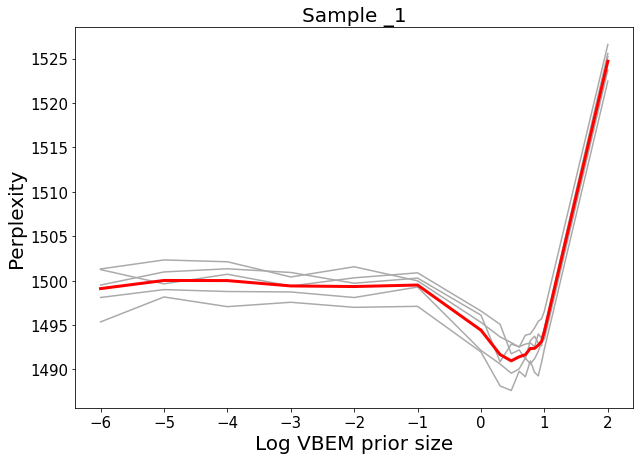

The smallest perplexity is 1487
The VBEM at the smallest perplexity is 3.0


In [3]:
def perplexity_plot(sample, vb_priors, folds):
    df = pd.DataFrame()
    for vb_prior in vb_priors:
        for fold in range(1, folds + 1):
            with open(perp_fp_fmt.format(sample=sample, vb_prior=vb_prior, fold=fold), 'r') as f:
                perp_result = yaml.safe_load(f)
            _vb_prior = float(vb_prior)
            df = df.append(dict(perplexity=perp_result['smoothed_perplexity'],
                                vb_prior=_vb_prior, log_vb_prior = np.log10(_vb_prior),
                                fold=fold), 
                           ignore_index=True)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.set_title('Sample {}{}'.format(sample[-3], sample[-1]), fontsize=20)
    sns.lineplot(x="log_vb_prior", y="perplexity", data=df, ax=ax, units="fold", estimator=None, color='#AAAAAA')
    sns.lineplot(x="log_vb_prior", y="perplexity", data=df, ax=ax, err_style=None, lw=3, color="red")

    ax.set_ylabel('Perplexity', fontsize=20)
    ax.set_xlabel('Log VBEM prior size', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()
    # find the log VBEM of the minimum perplexity and convert to base 10
    smallest = df.nsmallest(1, 'perplexity')
    print('The smallest perplexity is ' + str(int(smallest['perplexity'].values[0])))
    print('The VBEM at the smallest perplexity is ' + str(10**smallest['log_vb_prior'].values[0]))
    return ax

for sample in SAMPLES:
    perplexity_plot(sample, VB_PRIORS, 5)

The x-axis is the log 10 VBEM prior size, and the y-axis is the perplexity. Each gray line is the perplexity and associated VBEM prior for each fold. The red line is the average perplexity per VBEM and fold.

## Select the VBEM with the smallest perplexity

Since perplexity is a proxy for the error of an estimate, we should select the VBEM that produces the smallest perplexity. The minimum perplexity is present in the dip between 0 and 1, and the corresponding prior is 3. Therefore we should run Salmon with `--vbprior=3` for this sample; the resulting estimate should be the best to use for downstream analysis such as differential expression. Note that the optimal prior as suggested by the smallest perplexity will depend on your sample, which is why the config file can take multiple samples.

Perplexity can also be used to investigate other RNA transcript quantification questions.

## How does read depth impact the optimal VBEM prior?

Increasing the sample size is a surefire way to improve the accuracy and confidence of an estimate. In RNA sequencing, the number of reads is known as the read depth. Most experiments require 5-200 million reads per sample, according to [Illumina](https://support.illumina.com/bulletins/2017/04/considerations-for-rna-seq-read-length-and-coverage-.html). Increasing the read depth also increases the likelihood of capturing rare transcripts. With this in mind, I hypothesize that the VBEM prior will decrease as the read depth increases. Intuitively, when there are more reads, we are more certain to find rare transcripts, so we can assign a lower prior to them.

To test this hypothesis, I'll use holdout evaluation on different samples of 10 to 40 million reads drawn from the same distribution (or organism), with a test set of 20 million reads. To keep it fair, I'll keep the test set the same for each sample. There's a caveat that different reads will be called impossible for each sample, but it should not get in the way of seeing a general trend.

If you just want to see the results, you can skip to the plots made with the perplexity outputs in `example/output/readdepth`. Otherwise keep reading.

### Simulate reads

Reads will be simulated with [Polyester](https://www.bioconductor.org/packages/release/bioc/html/polyester.html) with a distribution based on an abundance estimate. Modify `config-simul.yml` to declare your inputs

```yaml
# results will go in output/{exp-name}
exp_name: simul_reads
# reads to base the simulation off of
reads_dir: /fs/cbcb-lab/rob/students/jason/shared/COPD-raw-data/output
# transcript to generation abundance estimate
tx_path: /fs/cbcb-lab/rob/students/jason/shared/annotations/hg19_clean.fa
# name of samples to use
sample_names:
  - SRR1265600
```

Polyester only simulates a fixed number of reads dependent on the size of the estimate. In this instance each simulated sample is 14.7 million reads. This will take about half an hour.

```sh
snakemake --snakefile snakefiles/simul_data.snk --configfile snakefiles/config-simul.yml -j <n cores>
```

To combine the reads into test and train sets, run the `shuffle-reads.sh` script in the directory that the reads were generated in. This will take a few hours to complete. Make sure you have enough disk space too because this will create several uncompressed copies of fasta files.

```sh
cd ../output/simul_reads/simulated_reads/SRR1265600
sh {repo directory}/scripts/shuffle-reads.sh
```

### Quantify and validate

Finally edit `snakefiles/config-readdepth.yml`, and specify the samples that we simulated.

```yaml
read_file_fmt: fasta
reads-dir: /fs/cbcb-lab/rob/students/skylar/perplexity/output/simul_reads/simulated_reads/SRR1265600
sample-names:
  - 10_million_reads
  - 20_million_reads
  - 30_million_reads
  - 40_million_reads
  # include more reads for later analysis
  - 50_million_reads
  - 60_million_reads
  - 70_million_reads
  - 80_million_reads
```

Then run the Snakefile for read depth, which will do quantification and holdout validation with the quants of each sample against the test reads. Make sure to use a small `-j`. This can take several hours, maybe even a day or two, so feel free to work on something else and come back.

```sh
snakemake --snakefile snakefiles/readdepth.snk --configfile snakefiles/config-readdepth.yml -j <n cores>
```

### Plot perplexity and log VBEM for samples of varying read depth

Welcome back. Let's plot the perplexities against log VBEM again. Since we did holdout validation and not k-folds cross-validation, there will only be one line to plot per sample.

In [4]:
# if you ran the pipeline for real earlier, just use ../output/{so on}
perp_fp_fmt = '../example/output/readdepth/perplexity/{sample}/vbprior={vb_prior}/beta=1e-8/perplexity.yml'

exp_config = '../snakefiles/config-readdepth.yml'
with open(exp_config, 'r') as f:
    cfg = yaml.safe_load(f)
    # only select first 4 for now
    SAMPLES = cfg['sample-names'][:4]
    VB_PRIORS = [str(w) for w in cfg['prior-weights']]

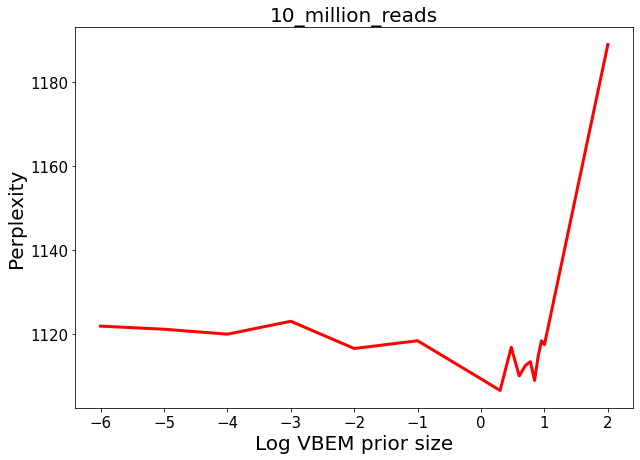

The smallest perplexity is 1106
The VBEM at the smallest perplexity is 2.0


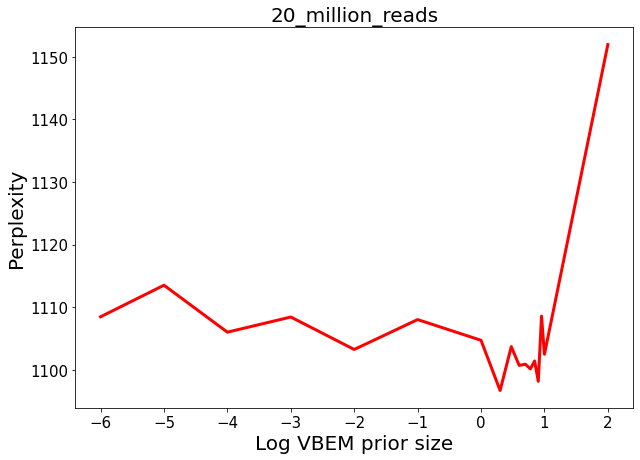

The smallest perplexity is 1096
The VBEM at the smallest perplexity is 2.0


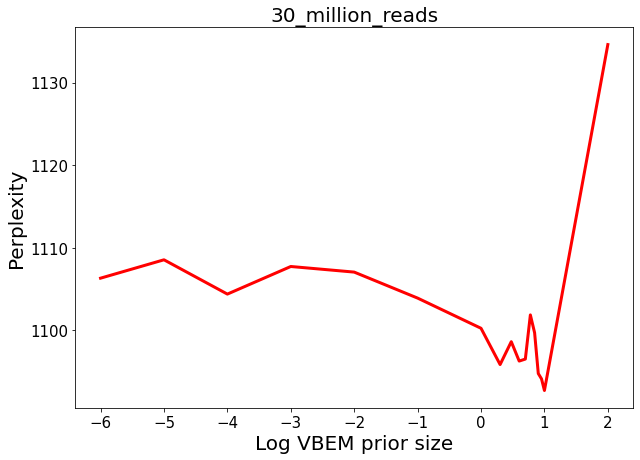

The smallest perplexity is 1092
The VBEM at the smallest perplexity is 10.0


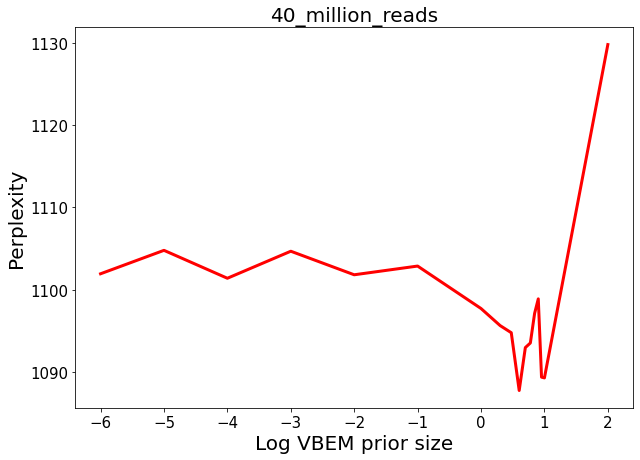

The smallest perplexity is 1087
The VBEM at the smallest perplexity is 4.0


In [5]:
def perplexity_plot_readdepth(sample, vb_priors):
    df = pd.DataFrame()
    for vb_prior in vb_priors:
        with open(perp_fp_fmt.format(sample=sample, vb_prior=vb_prior), 'r') as f:
            perp_result = yaml.safe_load(f)
        _vb_prior = float(vb_prior)
        df = df.append(dict(perplexity=perp_result['smoothed_perplexity'],
                            vb_prior=_vb_prior, log_vb_prior = np.log10(_vb_prior)), 
                       ignore_index=True)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    ax.set_title(sample, fontsize=20)
    sns.lineplot(x="log_vb_prior", y="perplexity", data=df, ax=ax, err_style=None, lw=3, color="red")

    ax.set_ylabel('Perplexity', fontsize=20)
    ax.set_xlabel('Log VBEM prior size', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()
    # find the log VBEM of the minimum perplexity and convert to base 10
    smallest = df.nsmallest(1, 'perplexity')
    print('The smallest perplexity is ' + str(int(smallest['perplexity'].values[0])))
    print('The VBEM at the smallest perplexity is ' + str(10**smallest['log_vb_prior'].values[0]))
    return ax

for sample in SAMPLES:
    perplexity_plot_readdepth(sample, VB_PRIORS)

Observe that the smallest perplexity decreases with increasing read depth. However the VBEM prior doesn't seem to be correlated with read depth. It could be possible that the optimal VBEM is independent of read depth, but we'd need some more experiments to support this.

## Conclusion

In this tutorial we demonstrated VBEM prior selection with RNA perplexity using k-fold cross validation and holdout validation. We also walked through some key highlights of the process:

1. Perplexity is a proxy for RNA transcript abundance accuracy and can be used to select the best VBEM prior for a sample.

2. Different samples can have different perplexities and priors.

3. Increasing read depth lowers perplexity, amd it is not clear yet whether it affects the best prior.

While perplexity is not a one-size fits all (samples) approach, it can help us produce more accurate RNA transcript abundance estimates. This will improve the results of downstream analysis and the biological insights that follow.

## Footnotes
<span id="fn1">1.</span> Currently the kfold script does not work for some read sets. A Rust rewrite for correct functionality and improved performance is planned for the future.

<span id="fn2">2.</span> If you run Snakemake will all cores while other users who want to run jobs at the same time, they **will** get annoyed with you.

<span id="fn3">3.</span> Salmon collapses reads into equivalence classes during quantification to reduce time and memory usage. Perplexity also uses equivalence classes because computing the approximate likelihood over each equivalence class is faster than computing the real likelihood over each possible alignment for all fragments.